# Init Tdx 

In [1]:
# import logging
import sys

# stdout=sys.stdout
sys.path.append('../../')
import os
import random
import time

import matplotlib
import matplotlib.pyplot as plt
import mplfinance as mpf
# pip install --upgrade mplfinance
# sys.stdout=stdout
import numpy as np
# import numpy as np
import pandas as pd
from JohnsonUtil import commonTips as cct
from JSONData import sina_data
from JSONData import tdx_data_Day as tdd
from mplfinance.original_flavor import candlestick_ohlc

# from JSONData import tdx_hdf5_api as h5a

%matplotlib widget
plt.rc('font', family='SimHei', size=13)
matplotlib.get_backend()
# jupyter nbextension enable --py widgetsnbextension

os.environ['NUMEXPR_MAX_THREADS'] = '12'
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
import nest_asyncio

nest_asyncio.apply()

In [2]:
# code_list = sina_data.Sina().all.index.tolist()
# print(f'code_list:{len(code_list)}')
# df = tdd.search_Tdx_multi_data_duration('tdx_all_df_300', 'all_300', df=None,code_l=code_list, start=20170101, end=None,freq=None, col=None, index='date')

In [3]:
block_path = tdd.get_tdx_dir_blocknew() + '060.blk'

## 功能定义DEF

### ra_diff


In [4]:
def ra_diff(df):
    df['ra_diff'] = df.close.apply(lambda x: round(x / df.close.min(), 2))
    return df

### bullish 测算

In [5]:
import numpy as np


def calculate_slope(data):
    # Calculate the slope of the line that connects two points
    slope = round((data[1] - data[0]) / (1), 2)
    return slope


def detect_bull_bear(price_data, window=10):
    # Calculate the slopes of the price data for the last `window` days
    slopes = []
    for i in range(len(price_data) - window, len(price_data) - 1):
        slope = calculate_slope([price_data[i], price_data[i + 1]])
        # print(slope)
        slopes.append(slope)

    # Compare the current slope with the average slope of the last `window` days
    avg_slope = round(np.mean(slopes), 2)
    curr_slope = calculate_slope([price_data[-window], price_data[-1]])
    print(len(slopes), avg_slope, curr_slope)

    if curr_slope > avg_slope:
        # return "Bullish"
        return "Bull"
    else:
        return "Bear"


def detect_bull_bear_apply(price_data, window=10):
    # Calculate the slopes of the price data for the last `window` days
    slopes = []
    # try:
    if len(price_data) > 20:
        for i in range(len(price_data) - window, len(price_data) - 1):
            slope = calculate_slope([price_data[i], price_data[i + 1]])
            # print(slope)
            slopes.append(slope)

        # Compare the current slope with the average slope of the last `window` days
        avg_slope = round(np.mean(slopes), 2)
        curr_slope = calculate_slope([price_data[-window], price_data[-1]])
        # print(len(slopes), avg_slope, curr_slope)

        # if curr_slope > avg_slope:
        #     # return "Bullish"
        #     return "Bull"
        # else:
        #     return "Bear"
        return curr_slope
    else:
        return round((price_data[-1] - price_data[0]) / (1), 2)


code = '601360'
# Example usage
# price_data = [100, 95, 97, 99, 102, 105, 108, 111,1]
dfc = tdd.get_tdx_Exp_day_to_df(
    code, dl=60, resample='d').sort_index(
    ascending=True).reset_index()
# dfc = get_sina_data_cname(dfc)
price_data = dfc.close.values.tolist()
price_data[1], dfc.date[0]
price_data[-1], dfc.date[-1:]
print(detect_bull_bear(price_data))
print(detect_bull_bear_apply(price_data))

# Output: "Bullish"

(10.59, '2025-03-24')

(10.0,
 55    2025-06-16
 Name: date, dtype: object)

9 -0.01 -0.08
Bear
-0.08


### regression_line(X, Y)
regression_ratio(df, window=10):

10.12 0.0
Above
0.0


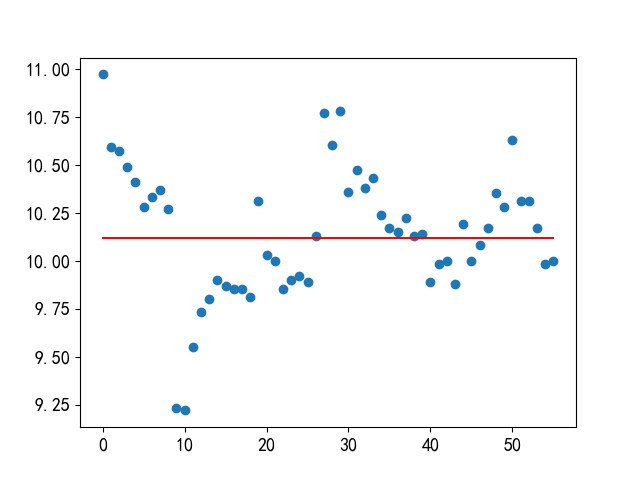

In [6]:


def regression_line(X, Y, limit=10,showall=False):
    # Calculate the coefficients of the regression line
    if not showall:
        X = X[-limit:]
        Y = Y[-limit:]
    n = len(X)
    sum_x = np.sum(X)
    sum_y = np.sum(Y)
    sum_xy = np.sum(X * Y)
    sum_xx = np.sum(X * X)
    a = round((sum_y * sum_xx - sum_x * sum_xy) / (n * sum_xx - sum_x * sum_x), 2)
    b = round((n * sum_xy - sum_x * sum_y) / (n * sum_xx - sum_x * sum_x), 2)
    return a, b


def regression_ratio(df, window=10):
    # Calculate the coefficients of the regression line
    if isinstance(df, pd.Series):
        # Y = df.values[-window:]
        # X = df.reset_index().index[-window:]
        Y = df.values
        X = df.reset_index().index
    else:
        if 'close' in df.columns:
            df = df.reset_index()
            # X = df.index[-limit:]
            # Y = df.close[-limit:]
            X = df.index
            Y = df.close
        else:
            # Y = df.values[-limit:]
            # X = df.reset_index().index[-limit:]
            Y = df.values
            X = df.reset_index().index
            
    n = len(X)
    sum_x = np.sum(X)
    sum_y = np.sum(Y)
    sum_xy = np.sum(X * Y)
    sum_xx = np.sum(X * X)
    # a = round((sum_y * sum_xx - sum_x * sum_xy) / (n * sum_xx - sum_x * sum_x),2)
    b = round((n * sum_xy - sum_x * sum_y) / (n * sum_xx - sum_x * sum_x), 2)
    return b


def predict_price(time, a, b):
    # Predict the price using the regression line
    price = a + b * time
    return price


def plot_regression_line(X, Y, a, b):
    # Plot the regression line
    # plt.close()
    plt.scatter(X, Y)
    plt.plot(X, a + b * X, color="red")
    plt.show()


def detect_position(price, a, b, X):
    # Detect the position of the current price on the regression line
    regression_price = predict_price(X[-1], a, b)
    if price > regression_price:
        return "Above"
    elif price < regression_price:
        return "Below"
    else:
        return "On"


# Example usage
time_index = dfc.index
price = dfc.close.values
a, b = regression_line(time_index, price,showall=True)
print(a, b)
# Output: (100.0, 5.0)
print(detect_position(132, a, b, time_index))
print(regression_ratio(dfc))
plot_regression_line(time_index, price, a, b)

# print(detect_position(132, a, b, time))
# Output: "On"

10.12 0.0
Above
0.0


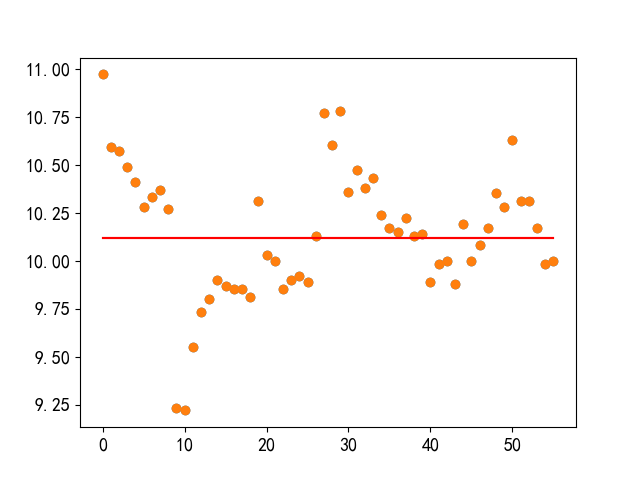

In [7]:


def regression_line(X, Y, limit=10,showall=False):
    # Calculate the coefficients of the regression line
    if not showall:
        X = X[-limit:]
        Y = Y[-limit:]
    n = len(X)
    sum_x = np.sum(X)
    sum_y = np.sum(Y)
    sum_xy = np.sum(X * Y)
    sum_xx = np.sum(X * X)
    a = round((sum_y * sum_xx - sum_x * sum_xy) / (n * sum_xx - sum_x * sum_x), 2)
    b = round((n * sum_xy - sum_x * sum_y) / (n * sum_xx - sum_x * sum_x), 2)
    return a, b


def regression_ratio(df, window=10):
    # Calculate the coefficients of the regression line
    if isinstance(df, pd.Series):
        # Y = df.values[-window:]
        # X = df.reset_index().index[-window:]
        Y = df.values
        X = df.reset_index().index
    else:
        if 'close' in df.columns:
            df = df.reset_index()
            # X = df.index[-limit:]
            # Y = df.close[-limit:]
            X = df.index
            Y = df.close
        else:
            # Y = df.values[-limit:]
            # X = df.reset_index().index[-limit:]
            Y = df.values
            X = df.reset_index().index
            
    n = len(X)
    sum_x = np.sum(X)
    sum_y = np.sum(Y)
    sum_xy = np.sum(X * Y)
    sum_xx = np.sum(X * X)
    # a = round((sum_y * sum_xx - sum_x * sum_xy) / (n * sum_xx - sum_x * sum_x),2)
    b = round((n * sum_xy - sum_x * sum_y) / (n * sum_xx - sum_x * sum_x), 2)
    return b


def predict_price(time, a, b):
    # Predict the price using the regression line
    price = a + b * time
    return price


def plot_regression_line(X, Y, a, b):
    # Plot the regression line
    # plt.close()
    plt.scatter(X, Y)
    plt.plot(X, a + b * X, color="red")
    plt.show()


def detect_position(price, a, b, X):
    # Detect the position of the current price on the regression line
    regression_price = predict_price(X[-1], a, b)
    if price > regression_price:
        return "Above"
    elif price < regression_price:
        return "Below"
    else:
        return "On"


# Example usage
time_index = dfc.index
price = dfc.close.values
a, b = regression_line(time_index, price,showall=True)
print(a, b)
# Output: (100.0, 5.0)
print(detect_position(132, a, b, time_index))
print(regression_ratio(dfc))
plot_regression_line(time_index, price, a, b)

# print(detect_position(132, a, b, time))
# Output: "On"

In [8]:
dfc.columns

Index(['date', 'code', 'open', 'high', 'low', 'close', 'vol', 'amount', 'ma5d',
       'ma10d',
       ...
       'low4', 'lastdu4', 'macddif', 'macddea', 'macdlast1', 'macdlast2',
       'macdlast3', 'macdlast4', 'macdlast5', 'macdlast6'],
      dtype='object', length=172)

### check_postion_vol_price

In [9]:
from sklearn.linear_model import LinearRegression


def check_postion_vol_price(df):
    # 加载数据
    # df = pd.read_csv("data.csv")

    # 创建输入数据
    X = df[["close", "vol"]].values
    y = df["close"].values

    # 训练回归模型
    reg = LinearRegression().fit(X, y)

    # 计算斜率和截距
    slope = reg.coef_[0]
    intercept = reg.intercept_

    # 计算上轨和下轨
    upper_band = slope * df["close"] + intercept + 2 * df["vol"]
    lower_band = slope * df["close"] + intercept - 2 * df["vol"]

    # 判断价格是否在通道内
    df["Positon"] = np.where(
        df["close"] > upper_band, "Long", np.where(
            df["close"] < lower_band, "Short", "Neutral"))
    return df


dfc = check_postion_vol_price(dfc)
dfc[-1:]

date    code  open  high  low  close         vol       amount  \
55  2025-06-16  601360   9.9  10.0  9.9   10.0  34308742.0  343336736.0   

     ma5d  ma10d  ...   lastdu4  macddif  macddea  macdlast1  macdlast2  \
55  10.15  10.23  ...  1.027916    -0.01     0.01      -0.03      -0.01   

    macdlast3  macdlast4  macdlast5  macdlast6  Positon  
55       0.04       0.07       0.08       0.09  Neutral  

[1 rows x 173 columns]

In [10]:

# dfc=  dfc.rename(columns={'date': 'Date', "open":"Open","high":"High","low": "Low","close":"Close"})
dfc.columns
# dfc[["Date", "Open", "High", "Low", "Close"]][-2:]
dfc.date[:3]
dfc.date = pd.to_datetime(dfc.date)
# dfc.set_index('date')
dfc.date[-1:]

Index(['date', 'code', 'open', 'high', 'low', 'close', 'vol', 'amount', 'ma5d',
       'ma10d',
       ...
       'lastdu4', 'macddif', 'macddea', 'macdlast1', 'macdlast2', 'macdlast3',
       'macdlast4', 'macdlast5', 'macdlast6', 'Positon'],
      dtype='object', length=173)

0    2025-03-24
1    2025-03-25
2    2025-03-26
Name: date, dtype: object

55   2025-06-16
Name: date, dtype: datetime64[ns]

### show_ohlc_upper 

xratio:0.0 
code: 601360


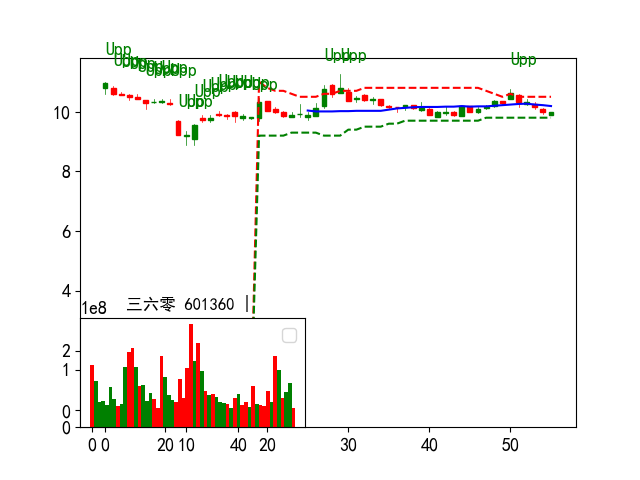

In [11]:

def show_ohlc_upper(df, code=None, allshow=True):
    # 加载数据
    # df = pd.read_csv("data.csv")
    # plt.close()
    # 计算OHLC数据
    # df = df.rename(columns={'date': 'Date', "open": "Open",
    #                "high": "High", "low": "Low", "close": "Close"})
    # df.Date = df.Date.apply(lambda x:str(x).replace('-',''))
    if 'name' not in df.columns and code is not None:
        df['name']= tdd.get_sina_data_code(code)
    if allshow:
        if 'ra_diff' in df.columns:
            print("xratio:%s ra_diff:%s" % (regression_ratio(df),df.ra_diff[-1]))
        else:
            print("xratio:%s " % (regression_ratio(df)))
    # df=df[df.upper > 0]
    df = df.rename(columns={'vol': 'volume'})
    df = df.reset_index()
    # df.date = pd.to_datetime(df.index)
    df.date = df.index
    # print(df.Date)
    # ohlc = df[["Date", "Open", "High", "Low", "Close"]].values
    ohlc = df[["date", "open", "high", "low", "close", 'volume']].values

    # 计算上轨和下轨
    # upper_band = df[df.upper != 0].upper
    # lower_band = df[df.lower != 0].lower
    upper_band = df.upper
    lower_band = df.lower
    
    # print(lower_band,df.lower)
    # print(upper_band,df.upper)

    if 'ma20d' in df.columns:
        ma20d = df[df.ma20d > 0].ma20d
    elif 'ma20' in df.columns:
        ma20d = df[df.ma20 > 0].ma20
    else:
        print('not ma20 ma20d')
    idx = len(df) - len(upper_band)
    idx2 = len(df) - len(lower_band)
    if idx != idx2:
        print(idx, len(df), len(upper_band))
        print(idx2, len(lower_band))

    # 计算当前价格的位置
    position = ['' for i in range(len(df))]
    # print(idx,len(df) ,len(upper_band),position)
    
        # else:
            # position[i] = 'Middle Band'
    # print(position)
    # 绘制OHLC图
    fig, ax = plt.subplots()
    candlestick_ohlc(ax, ohlc, width=0.6, colorup='g', colordown='r')

    # 添加上轨和下轨
    
    for i in range(idx, len(upper_band), 1):
        # print(df["close"][i])
        # print(upper_band[i],df["low"][i])
        # print(i,lower_band[i])
        #error upper_band ==0.0
        if df["close"][i] > upper_band[i]:
            position[i] = 'Upp'
        elif df["low"][i] < lower_band[i]:
            position[i] = 'Low'
            
    plt.plot(upper_band.index, upper_band, 'r--', label='Upper Band')
    plt.plot(lower_band.index, lower_band, 'g--', label='Lower Band')
    
    plt.plot(ma20d.index, ma20d, 'b', label='ma20')

    if 'hat' in df.columns:
        plt.plot(df.hat.index, df.hat, 'g', label='hat')
    # 添加位置
    for i, txt in enumerate(position):
        if txt == 'Low':
            plt.annotate(txt, (df["date"][i], df["close"][i]), xytext=(
                0, -30), textcoords='offset points', color='g')
        else:
            plt.annotate(txt, (df["date"][i], df["close"][i]), xytext=(
                0, 20), textcoords='offset points', color='g')
    axx = fig.add_subplot(325)
    # axx.plot(df[["volume"]])
    # from matplotlib import transforms
    # pad = 0.25
    # yl = ax.get_ylim()
    # ax.set_ylim(yl[0]-(yl[1]-yl[0])*pad,yl[1])
    # axx = ax.twinx()
    # axx.set_position(transforms.Bbox([[0.125,0.1],[0.9,0.32]]))

    volume = np.asarray(df.volume)
    pos = df['open'] - df['close'] < 0
    neg = df['open'] - df['close'] >= 0
    idx = np.asarray([x for x in range(len(df.date))])
    # print len(dates),len(df),ax.get_xlim(),ax.get_xticks()
    axx.bar(idx[pos], volume[pos], color='red', width=1, align='center')
    axx.bar(idx[neg], volume[neg], color='green', width=1, align='center')

    # position = ['' for i in range(len(df))]
    # position = df.Positon
    # for i, txt in enumerate(position):
    #     plt.annotate(txt, (df["Date"][i], df["Close"][i]), xytext=(0,20), textcoords='offset points')
    # 添加图例
    plt.legend(loc='best')
    # plt.legend(["Now:%s" % df.close[-1], "Hi:%s" % df.high[-1], "Lo:%0.2f" % (asset.iat[-1]), "day:%s" %
    #             len(asset), "fib:%s" % (fib),"MA:%s"%(roll_mean_days)], fontsize=12, loc=0)
    if 'name' in df.columns:
        if 'code' in df.columns:
            plt.title(df.name.values[-1:][0] + " " + df.code[0] + " | ", fontsize=12)
        else:
            plt.title(str(df.name.values[-1:][0]) + " " + " | ", fontsize=12)

    else:
        if 'code' in df.columns:
            plt.title(" | " + df.code[0] + " | ", fontsize=12)
        else:
            if code is None:
                plt.title(" | " + " | ", fontsize=12)
            else:
                plt.title(" | " + code + " | ", fontsize=12)

    # 显示图形
    print("code:",code)
    plt.show()


show_ohlc_upper(dfc,code=dfc.code[0])

In [12]:
'code' in dfc.columns

True

### show_channel_mpl

In [13]:
dfc['position'] = 0


def show_channel_mpl_bug(df, limit=60):
    # Compute the channel
    def compute_channel(df):
        # Compute the high and low of the past n periods
        n = 20
        high = df['high'].rolling(window=n, min_periods=n).max()
        low = df['low'].rolling(window=n, min_periods=n).min()
        df['upper_channel'] = high + (high - low) * 0.5
        df['lower_channel'] = low - (high - low) * 0.5

        # Update the position based on the current price
        df['position'] = np.where(df['close'] > df['upper_channel'] * 0.66, 1,
                                  np.where(df['close'] < df['lower_channel'], -1, 0))
        # print(df['position'])

    df = df.rename(columns={'vol': 'volume'})
    # df = df.reset_index()
    if 'date' in df.columns:
        df.date = pd.to_datetime(df.date)
    else:
        df = df.reset_index()
        df.date = pd.to_datetime(df.date)
    df = df.set_index('date')
    # df.date = df.index
    df = df.loc[:, ["open", "high", "low", "close", 'volume']]
    compute_channel(df)

    # fig, ax = plt.subplots()
    # Plot the ohlc chart
    mpf.plot(df, type='candle', title='OHLC chart with channel and position',
             ylabel='Price', volume=True, mav=(10, 20),
             show_nontrading=False, ylabel_lower='Position')
    # returnfig=True)

    # for i, txt in enumerate(df.position):
    #     # print(i,txt,df.index[i], df["close"][i])
    #     if txt == 0:
    #         plt.annotate("Down", (df.index[i], df["close"][i]), xytext=(
    #             0, -30), textcoords='offset points', color='g')
    #     else:
    #         plt.annotate("UP", (df.index[i], df["close"][i]), xytext=(
    #             0, 20), textcoords='offset points', color='g')

    # axlist[0].set_yticks([-1, 0, 1])
    # axlist[2].xaxis.set_ticks(df['position'])
    # axlist[2].set_xticklabels(df['upper_channel'])
    # yticks=[-1, 0, 1], yticklabels=['Sell', 'Hold', 'Buy'],
    # overlays=[(df['upper_channel'], None), (df['lower_channel'], None)])
# show_channel_mpl(dfc)

## TDX def

In [14]:
global sina_dm
sina_dm = None


def get_sina_data_cname(df, dm=None, index=False, realtime=False):
    # index_status=False
    global sina_dm
    if dm is None:
        if sina_dm is None:
            dm = sina_data.Sina().market('all')
        else:
            dm = sina_dm.copy()

    if 'ticktime' in df.columns:
        time_l = time.mktime(dm.loc[:, 'ticktime'][-1].timetuple())
        dur = round((time.time() - time_l) / 60, 2)
        if dur > 5:
            print("timel > 5,renew dm")
            dm = sina_data.Sina().market('all')
            sina_dm = dm.copy()

    if realtime:
        print("compute percent")
        df.rename(columns={'low': 'llow',
                  'high': 'lhigh', 'open': 'lopen'}, inplace=True)
        if 'nclose' in dm.columns:
            dd = cct.combine_dataFrame(
                df, dm.loc
                [:,
                 ['nclose', 'close', 'name', 'open', 'high', 'low', 'llastp',
                  'ticktime']],
                clean=True)
        else:
            dd = cct.combine_dataFrame(
                df, dm.loc
                [:, ['close', 'name', 'open', 'high', 'low', 'llastp', 'ticktime']],
                clean=True)
        dd['perc'] = ((dd['close'] - dd['llastp']) / dd['llastp'] *
                      100).map(lambda x: round(x, 2))
        # dd = cct.combine_dataFrame(df, dm['name'])

    else:
        dd = cct.combine_dataFrame(df, dm['name'])
    # cname = sina_data.Sina().get_code_cname(code)
    return dd


def write_code_to_blk(codew, blk='060'):
    block_path = tdd.get_tdx_dir_blocknew() + '%s.blk' % (blk)
    write_blk = 'n'
    write_blk = cct.cct_raw_input("write blk [Y] or [N]:")
    if write_blk == 'y' or write_blk == 'Y':
        hdf5_wri = cct.cct_raw_input(
            "Rewrite code [Y] or append [N](defalut:N):")
        if hdf5_wri == 'y' or hdf5_wri == 'Y':
            append_status = False
        else:
            append_status = True
        if len(codew) > 3:
            cct.write_to_blocknew(block_path, codew, append_status,
                                  doubleFile=False, keep_last=0)
            ("write:%s block_path:%s" % (len(codew), block_path))
        else:
            ("write error:%s block_path:%s" % (len(codew), block_path))
    return True

def get_multiIndex_drop_last_row(df,dropline=1):

    return df.drop(level='date', labels=df.index.get_level_values('date')[-dropline])

def clean_688(df):
    df = df[(~df.index.str.contains("688"))]
    return df

def clean_sina_dm(dd):
    if (cct.get_now_time_int() > 915 and cct.get_now_time_int() < 926):
        dd = dd[dd.close > 0]
    else:
        dd = dd[dd.open > 0]
    return dd

def compute_perd_value(df, market_value=3, col="vol", col_new='volsum'):

    # if market_value == None or market_value < "2":
    #     market_value = 3
    # if market_value > 1 and len(df[ df["%s%sd" % (col, market_value)] > 2])   :
    market_value = str(market_value)
    if market_value > str(1):
        temp = df[
            df.columns[
                (df.columns >= "%s1d" % (col)) &
                (df.columns <= "%s%sd" % (col, market_value))
            ]
        ]

        df['%s%sd' % (col_new, market_value)] = temp.T.sum().apply(
            lambda x: round(x, 1))
    else:
        print("market_value <= 1,No Compute")

    return df


def show_tdx_data(df, codelist=None, market_value='3', col=None):
    col_src = [
        "name", "couts", "date", "perc", "ra_diff","xratio", "idx", "hat", "close",
        "volsum5d", "hmax", "lmin", "perc1d", "ma20", "ma250", "nclose",
        "llow", 'vol1d', 'vol2d', 'vol3d', 'vol4d', 'vol5d', "perc%sd" %
        (market_value),
        "perc5d"]

    if isinstance(df, pd.Series):
        col_name = [co for co in col_src if co in df.index]
        # col_name.insert(1,'date')
    else:
        col_name = [co for co in col_src if co in df.columns]

    # print(col_name)
    # if isinstance(df, pd.DataFrame) and 'name' in df.columns:
    #     columns_ = col_name
    # else:
    #     if isinstance(df, pd.Series) and 'name' in df.index:
    #         columns_ = col_name.insert(1, "date")
    #     else:
    #         columns_ = col_name.remove("name")
    
    if isinstance(col,list):
        col_name.extend(col)
    elif col is not None:
        col_name.insert(4, col)

    if codelist is None:
        if isinstance(df, pd.Series):
            print("Count:1")
            temp = df.loc[col_name]
        else:
            print("Count:%s %s" % (df.shape))
            temp = df.loc[:, col_name]
    else:
        temp = df.loc[[x for x in codelist if x in df.index], col_name]
    return temp


def get_multi_date_duration(df, dt):
    dd = df.reset_index()
    dd = dd[dd.date >= dt]
    # dd['couts'] = dd.groupby(['code'])['code'].transform('count')
    dd = dd.set_index(['code', 'date'])
    return dd


def get_multi_code_count(df, col='code'):
    dd = df.reset_index()
    dd['couts'] = dd.groupby([col])[col].transform('count')
    dd = dd.sort_values(by=['couts', 'date'], ascending=[0, 1])
    print('count dd.couts')
    dd = dd.set_index(['code', 'date'])
    return dd


def multindex_iloc(df, index):
    label = df.index.levels[0][index]
    return df.iloc[df.index.get_loc(label)]


def get_groupby_mean_median_close(dfs):

    groupd = dfs.groupby(level=[0])

    df = groupd['close'].agg(['median', 'mean'])
    df['close'] = groupd.tail(1).reset_index().set_index(['code'])['close']
    # dfs['mean'] = groupd['close'].agg('mean')
    # dfs['median'] = groupd['close'].agg('median')

    # dfs = dfs.fillna(0)
    # idx = pd.IndexSlice
    # mask = ( (dfs['mean'] > dfs['median'])
    #         & (dfs['close'] > dfs['mean'])
    #         )
    # df=dfs.loc[idx[mask, :]]

    df = df[(df['mean'] > df['median']) & (df['close'] > df['mean'])]

    # dt_low = None
    # if dl == 1:
    #     dfs = groupd.tail(1)
    #     print("dfs tail1")
    # else:
    #     dl = 30
    #     dindex = tdd.get_tdx_Exp_day_to_df(
    #         '999999', dl=dl).sort_index(ascending=False)
    #     dt = tdd.get_duration_price_date('999999', df=dindex)
    #     dt = dindex[dindex.index >= dt].index.values
    #     dt_low = dt[-1]
    #     dtlen = len(dt) if len(dt) >0 else 1
    #     dfs = groupd.tail(dtlen)
    #     print("dfs tail:%s dt:%s"%(dtlen,dt))
    #     dfs = get_multi_date_duration(dfs,dt[-1])
    return df


def compute_df_Col_lastday(dfs, col='close', colre='perc', days=3, plus=True):
    for da in range(int(days)):
        da += 1
        if plus:
            dfs['%s%sd' % (colre, da)] = round(
                (dfs[col] - dfs[col].shift(da)) / dfs[col].shift(da) * 100, 2)
        else:
            if da == 1:
                dfs['%s%sd' % (colre, da)] = round(
                    (dfs[col] - dfs[col].shift(da)) / dfs[col].shift(da) * 100, 2)
            else:
                dfs['%s%sd' % (colre, da)] = round(
                    (dfs[col].shift(da - 1) - dfs[col].shift(da)) / dfs[col].shift(da) * 100, 2)
    return dfs

In [15]:
def get_roll_mean_all(
        single=True, tdx=False, app=True, duration=100, ma_250_l=1.3,
        ma_250_h=1.3, resample='d'):
    time_s = time.time()
    if not app and cct.get_file_size(block_path) > 100 and cct.creation_date_duration(block_path) == 0:
        print("It's Today Update")
        return True
    code_list = sina_data.Sina().all.index.tolist()
#     .Sina().all.index.tolist()
    code_list.extend(['999999', '399001', '399006'])
    print("all code:", len(code_list))
    if duration < 300:
        h5_fname = 'tdx_all_df' + '_' + str(300)
        h5_table = 'all' + '_' + str(300)
    else:
        h5_fname = 'tdx_all_df' + '_' + str(900)
        h5_table = 'all' + '_' + str(900)
    print(f'h5_fname:{h5_fname} h5_table:{h5_table}')
#     df = tdd.search_Tdx_multi_data_duration('tdx_all_df_300', 'all_300', df=None,code_l=code_list, start='20170501', end=None, freq=None, col=None, index='date')
#     df = tdd.search_Tdx_multi_data_duration(h5_fname, h5_table, df=None, code_l=code_list, start=None, end=None,
#         freq=None, col=None, index='date')
    df = tdd.search_Tdx_multi_data_duration('tdx_all_df_300', 'all_300', df=None,code_l=code_list, start=20170101, end=None,freq=None, col=None, index='date')
    # df = tdd.search_Tdx_multi_data_duration(h5_fname, h5_table, df=None,code_l=code_list, start=None, end=None, freq=None, col=None, index='date',tail=1)
    print(f'df:{df}')
    code_uniquelist = df.index.get_level_values('code').unique()

    code_select = code_uniquelist[random.randint(0, len(code_uniquelist) - 1)]
    print(round(time.time() - time_s, 2), df.index.get_level_values(
        'code').unique().shape, code_select, df.loc[code_select].shape)
    # df.groupby(level=[0]),df.index.get_level_values(0)
    # len(df.index.get_level_values('code').unique())
    # df = df[~df.index.duplicated(keep='first')]

    # multiIndex_func = {'close': 'mean', 'low': 'min', 'high': 'max', 'volume': 'sum', 'open': 'first'}
    # cct.using_Grouper(df, freq='W', col={'close': 'last'})
    # *** TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'Index'
    # roll_dl = duration
    if resample != 'd':

        print("resample:%s"%(resample.upper()))
        df = df.groupby(level=0).resample(resample, level=1).last()
        df = df.dropna()
        
    ''' 
    if resample != 'd':
        print("resample:%s" % (resample.upper()))
        # ohlc_dict = {'volume': 'sum','high': 'max','low': 'min','close': 'last'}
        # {'low': 'min', 'close':'mean'}
        # df = df.groupby(level=0).resample(resample, level=1).agg({'close':'last'})
        # df = df.loc[:, ['open','close', 'low', 'high']].groupby(level=0).resample(resample, level=1).agg({'close':'last'})
        df = df.loc[:, ['close']].groupby(level=0).resample(
            resample, level=1).agg({'close': 'last'}).dropna()

        df = df.dropna()
        # df = df.loc[:, ['open','close', 'low', 'high']].groupby(level=0).resample(resample, level=1, how={'low': 'min', 'close':'mean'})
        # df = df.loc[:, ['open','close', 'low', 'high']].groupby(pd.Grouper(freq=resample)).transform(np.cumsum).resample(resample, how='ohlc')

        # df = df.loc[:, ['open','close', 'low', 'high']].groupby(pd.TimeGrouper(resample)).transform(np.cumsum).resample(resample, how='ohlc')
        # r1 = len(df.loc['000001'])
        # r2 = len(df.loc['999999'])
        # roll_dl = r1 if r1 < r2 else r2

        # df['upper'] = map(lambda x: round((1 + 11.0 / 100) * x, 1), df.ma10d)
        # df['lower'] = map(lambda x: round((1 - 9.0 / 100) * x, 1), df.ma10d)
        # df['ene'] = map(lambda x, y: round((x + y) / 2, 1), df.upper, df.lower)
        # dfs['amount%d'%cumdays] = groupd['amount'].apply(pd.rolling_mean, cumdays)
    # df.ix[df.index.levels[0]]
    # df.ix[df.index[len(df.index)-1][0]] #last row
    # dfs = tdd.search_Tdx_multi_data_duration(df=dfs,code_l=code_list, start='20170918', end='20170918', freq=None, col=None, index='date')

    # print dfs[:1],len(dfs)
    # groupd.agg({'low': 'min'})
    #  idx mask filter 
    # h5a.write_hdf_db('all300', df, table='roll200', index=False,baseCount=500, append=False, MultiIndex=MultiIndex)
    '''

    df = df.reset_index().sort_values(by=['code', 'date'], ascending=[0, 1]).set_index(['code', 'date'])
    print("use time:%s" % (round(time.time() - time_s, 2)))
    return df

# 读取数据 TDX Days

## resample = 'D'

In [16]:
# resample = 'W-FRI'
resample = 'D'

df = get_roll_mean_all(
    single=False, tdx=True, app=True, duration=250, ma_250_l=1.2,
    ma_250_h=1.2, resample=resample)


# df= df.groupby(level=[0]).tail(1).reset_index().set_index('code')
# df_cname = tdd.get_sina_datadf_cnamedf(df.index.tolist(), df)
# df = df.reset_index().set_index(['code', 'date'])

all code: 5197
h5_fname:tdx_all_df_300 h5_table:all_300
df:                     open    high     low   close           vol        amount
code   date                                                                  
999999 2024-03-20  3058.0  3082.0  3056.0  3080.0  3.491877e+10  1.071727e+14
       2024-03-21  3084.0  3090.0  3070.0  3078.0  3.668780e+10  1.129859e+14
       2024-03-22  3070.0  3074.0  3028.0  3048.0  3.947405e+10  1.204150e+14
       2024-03-25  3040.0  3066.0  3026.0  3026.0  3.874854e+10  1.180197e+14
       2024-03-26  3026.0  3036.0  3006.0  3032.0  3.459288e+10  1.045181e+14
...                   ...     ...     ...     ...           ...           ...
300296 2025-06-16     5.8     5.9     5.8     5.8  3.333350e+07  1.945074e+08
300803 2025-06-16    61.0    62.6    60.9    62.3  1.621754e+07  1.005179e+09
300455 2025-06-16    13.5    13.6    13.4    13.6  1.168139e+07  1.579964e+08
301207 2025-06-16    16.5    16.6    16.4    16.5  1.943300e+06  3.201789e+07
30023

In [17]:
# df.loc['399001'][-1:]
df.loc['000002'][-1:]
# df.groupby(level=[0]).tail(30).groupby(level=[0]).tail(2)
# df.groupby(level=[0]).tail(30).groupby(level=[0]).head(1)

open  high  low  close          vol       amount
date                                                        
2025-06-16   6.5   6.6  6.4    6.6  130234808.0  852638656.0

### Test InStock

In [18]:
df.loc['301083'][:2]

open  high   low  close        vol      amount
date                                                      
2024-03-20  15.4  15.5  15.2   15.4  6056930.0  93843040.0
2024-03-21  15.4  15.6  15.1   15.4  5771594.0  89267952.0

## ra_diff

In [19]:
tail_days = 60

In [20]:
df = df.groupby(level=[0]).tail(tail_days).groupby(level=[0]).apply(ra_diff)


In [21]:
# df.loc['999999'][-3:]
# df.loc['301073'].ra_diff[-3:]
df.loc['300459'].shape

(60, 7)

## X df_regression_ratio outdate
    df_idx_detect

In [22]:
# df_reg_ratio = df.groupby(level=[0])['close'].apply(regression_ratio)
# df_idx_detect = df.groupby(level=[0])['close'].apply(detect_bull_bear_apply)
# show_ohlc_upper()
# df[:10]

In [23]:
# df_idx_detect.shape, df_idx_detect.loc['000002']
# df.loc['000002'][-2:],df_reg_ratio.loc['000002']
# df.loc['688798'][-3:]

In [24]:
# df.loc['000002'][-10:]

## sina_dm

In [25]:
sina_dm = sina_data.Sina().market('all')
lastday = cct.last_tddate()
lastday,sina_dm.name[:1]
sina_dm = clean_sina_dm(sina_dm)

('2025-06-13',
 code
 300192    科德教育
 Name: name, dtype: object)

In [26]:
cct.get_time_to_date(time.time(), format='%Y-%D %H:%M:%S')

# abc=dm.loc[:,'ticktime'][-1]
sina_dm.ticktime[-2:]
# dm.ticktime[:1]
# sina_dm.loc[:, 'ticktime'][-1]
# time.strptime(abc,format='%Y-%m-%d %H:%M:%S')
# (time.mktime(abc.timetuple()))
(time.time() - time.mktime(sina_dm.loc[:, 'ticktime'][-1].timetuple())) / 60

'2025-06/16/25 22:14:07'

code
001387   2025-06-16 15:00:00
833030   2025-06-16 15:02:46
Name: ticktime, dtype: datetime64[ns]

431.35328349669777

### Combine ratio and idx

In [27]:
# if 'date' in df.columns:
#     print('error duplicated date col')
#     if isinstance(df,pd.MultiIndex):
#         df.drop('date', axis=1, inplace=True)
# else:
#     df = df.reset_index().set_index('code')
#     df['idx'] = df_idx_detect
#     df['xratio'] = df_reg_ratio
#     df['name'] = sina_dm.name
#     df = df.reset_index().set_index(['code', 'date'])

## 读取实时成交量数据

In [28]:
def apply_col_toint(df, col=None):
    if col is None:
        co2int = ['boll', 'op', 'ratio', 'fib', 'fibl', 'df2']
    # co2int.extend([co for co in df.columns.tolist()
    #                if co.startswith('perc') and co.endswith('d')])
        co2int.extend(['top10', 'topR'])
    else:
        co2int = col
    co2int = [inx for inx in co2int if inx in df.columns]

    for co in co2int:
        df[co] = df[co].astype(int)

    return df

def readHdf5(fpath, root=None):
    store = pd.HDFStore(fpath, "r")
    print(store.keys())
    if root is None and store is not None:
        root = store.keys()[0].replace("/", "")
    df = store[root]
    df = apply_col_toint(df)
    store.close()
    return df

In [29]:
# tdx_path = "G:\\tdx_last_df.h5"
# from JohnsonUtil import commonTips as cct
sina_MultiD_path = f"{cct.get_ramdisk_dir()}\\sina_MultiIndex_data.h5".replace('\\',os.sep)
print(f'sina_MultiD_path:{sina_MultiD_path}')
h5 = readHdf5(sina_MultiD_path)
print(sina_MultiD_path)
h5.shape
h5code='603019'
h5.loc[h5code][-3:]
code_muti = '603019'
# h5.loc[code_muti][:2]

freq = 'D'
# freq = '5M'
startime = '09:25:00'
endtime = '15:01:00'

time_ratio = cct.get_work_time_ratio()
time_ratio
run_col = ['close', 'volume']
# run_col = ['close']
mdf = cct.get_limit_multiIndex_freq(
    h5, freq=freq.upper(),
    col=run_col, start=startime, end=endtime, code=None)
allvol = mdf.volume.sum()
allvol = round(allvol / 10 / 1000 / 1000,2)
print("总量:%s 亿"%(allvol))
mdf['vol']=mdf['volume'].apply(lambda x: round(x /1000/1000,2)) 
mdf['amount']=(mdf.volume * mdf.close).map(lambda x: round(x/100/1000/1000, 2))
#全局占比
mdf['volume'] = mdf.amount.apply(
    lambda x: round(x / allvol * 100 / time_ratio, 2))
mdf=mdf.reset_index().set_index('code')
mdf.loc[h5code]

sina_MultiD_path:/Volumes/RamDisk/sina_MultiIndex_data.h5
['/all_30']
/Volumes/RamDisk/sina_MultiIndex_data.h5


(2757225, 6)

close  high    low  llastp    volume  lastbuy
ticktime                                                          
2025-06-16 14:59:26  68.82  69.8  68.11   68.49  26488117    68.97
2025-06-16 14:59:59  68.82  69.8  68.11   68.49  26488117    68.90
2025-06-16 15:00:01  68.82  69.8  68.11   68.49  26788917    68.97

1.0

总量:9714.59 亿


ticktime    2025-06-17 00:00:00
close                 69.020753
volume                     0.19
vol                       26.79
amount                    18.49
Name: 603019, dtype: object

In [30]:
mdf[:2]
mdf.loc['603019']

ticktime      close  volume     vol  amount
code                                                
000001 2025-06-17  11.665913    0.14  117.44   13.70
000002 2025-06-17   6.535585    0.09  130.23    8.51

ticktime    2025-06-17 00:00:00
close                 69.020753
volume                     0.19
vol                       26.79
amount                    18.49
Name: 603019, dtype: object

In [31]:
# h5.index.get_level_values('code')[0]
# help(h5.index.get_level_values)
str(h5.index.get_level_values(1)[-1])[:10]

'2025-06-16'

In [32]:
if len(mdf) > 0:
    mdf.loc['000002']
else:
    print("mdf is None")

ticktime    2025-06-17 00:00:00
close                  6.535585
volume                     0.09
vol                      130.23
amount                     8.51
Name: 000002, dtype: object

###  实时成交量个股Top!!!

In [33]:
nowdf = mdf.sort_values(by=['volume'], ascending=[0])
# nowdf.shape, df.shape, code_idx.shape
# top20_nd = nowdf.reset_index().loc[:, ['code', 'volume']][:20]
top20_nd = nowdf.reset_index().loc[:, ['code', 'volume']][:20]
top20_nd=get_sina_data_cname(top20_nd)

In [34]:
nowdf.shape,top20_nd

((5416, 5),
         volume   name
 code                 
 302132    0.36    NaN
 002384    0.85   东山精密
 300308    0.74   中际旭创
 300502    0.64    新易盛
 600519    0.63   贵州茅台
 300251    0.61   光线传媒
 300059    0.60   东方财富
 300468    0.59   四方精创
 300476    0.53   胜宏科技
 300773    0.47    拉卡拉
 600418    0.42   江淮汽车
 300085    0.40    银之杰
 600570    0.38   恒生电子
 002104    0.37   恒宝股份
 002594    0.36    比亚迪
 002190    0.34   成飞集成
 002130    0.34   沃尔核材
 000858    0.33  五 粮 液
 002463    0.33   沪电股份
 002583    0.33    海能达)

In [35]:
# show_tdx_data(top20_nd)
# top20_nd.columns

### 合并实时成交量及SinaDM

In [41]:
from JSONData import tdx_hdf5_api as h5a
def get_tdx_all_from_h5(resample='d',showtable=True):
    #sina_monitor
    h5_fname = 'tdx_last_df'
    resample=resample
    if resample=='d':
        dl='60'
    else:
        dl='200'
    filter='y'
    h5_table = 'low' + '_' + resample + '_' + str(dl) + '_' + filter + '_' + 'all'
    h5 = h5a.load_hdf_db(h5_fname, table=h5_table,code_l=None, timelimit=False,showtable=showtable)
    return h5


In [42]:
# mdf[:1]
sinadm = cct.combine_dataFrame(sina_dm, mdf[['vol','amount']])
sinadm['percent']=((sinadm['close']-sinadm['llastp'])/(sinadm['llastp'])*100).round(1)

In [43]:
h5tdx = get_tdx_all_from_h5(resample='w')
tdx_now_w = cct.combine_dataFrame(h5tdx,sinadm)

keys:['/low_3d_60_y_all', '/low_d_60_y_all', '/low_m_300_y_all', '/low_w_200_y_all']


In [44]:
tdx_now_w.query('close > lastp1d and lastp1d > lastp2d and lastp2d >lastp3d and close > high4')

lopen  lhigh  llow  lastp         lvol       lamount  ma5d  ma10d  \
code                                                                        
000001   10.6   10.7  10.1   10.5  568176768.0  6.665828e+09  11.2   11.0   
000159    5.2    5.2   4.2    4.9  121050408.0  6.842419e+08   5.5    5.3   
000403   15.9   16.0  15.4   15.6  234217552.0  4.215852e+09  16.9   17.0   
000408   27.7   27.8  26.8   27.1   54342648.0  2.141495e+09  37.4   36.4   
000430    6.4    6.4   5.8    5.8   53967076.0  4.203267e+08   7.6    7.6   
...       ...    ...   ...    ...          ...           ...   ...    ...   
872931   11.2   11.8  10.6   10.8   13435005.0  2.455662e+08  17.9   16.5   
920016   19.8   20.0  19.6   19.7   33314920.0  9.870497e+08  27.2   26.0   
920066   23.9   25.0  22.8   23.2    8085186.0  2.650847e+08  31.9   31.4   
920088   23.0   24.4  21.7   22.2   20427164.0  6.360100e+08  28.7   26.9   
920099   28.4   28.4  27.8   27.8   11781180.0  4.100415e+08  33.4   33.7   

        ma20d  ma60d  ...  close         nvol  lastbuy  nlow  nhigh  nclose  \
code                  ...                                                     
000001   11.1    0.0  ...   11.8  117443827.0     11.7  11.5   11.6    11.7   
000159    5.5    0.0  ...    6.1   54537583.0      6.0   5.8    6.0     6.0   
000403   16.5    0.0  ...   18.8   34218894.0     18.3  18.1   18.9    18.5   
000408   33.8    0.0  ...   40.8    8582440.0     40.6  40.5   41.6    40.7   
000430    7.2    0.0  ...    8.0    9801197.0      8.0   7.7    7.9     7.9   
...       ...    ...  ...    ...          ...      ...   ...    ...     ...   
872931   14.5    0.0  ...   20.3    5775059.0     20.0  18.6   19.7    19.8   
920016   24.3    0.0  ...   28.4    3032923.0     28.1  27.4   28.3    28.0   
920066   28.8    0.0  ...   34.5    1641492.0     34.1  33.4   34.4    34.2   
920088   25.7    0.0  ...   49.1   15221844.0     51.4  42.9   52.4    50.3   
920099   31.7    0.0  ...   35.3    4196603.0     35.1  34.1   35.5    35.1   

        nstd     vol  amount  percent  
code                                   
000001  -2.0  117.44   13.70      1.7  
000159  -2.0   54.54    3.26      5.2  
000403  -2.0   34.22    6.33      3.3  
000408  -2.0    8.58    3.49      0.7  
000430  -2.0    9.80    0.78      1.3  
...      ...     ...     ...      ...  
872931  -2.0    5.78    1.14      6.8  
920016  -2.0    3.03    0.85      0.4  
920066  -2.0    1.64    0.56      0.9  
920088  -2.0   15.22    7.66     19.5  
920099  -2.0    4.20    1.47      3.5  

[525 rows x 220 columns]

### tdx_last_df and Now sina!!! RealTIME

In [45]:
tdx_h5=get_tdx_all_from_h5()
tdx_now = cct.combine_dataFrame(tdx_h5,sinadm)

keys:['/low_3d_60_y_all', '/low_d_60_y_all', '/low_m_300_y_all', '/low_w_200_y_all']


In [46]:
tdx_now.shape
# tdx_now.query('close >  lastp1d  and lastl1d < ma51d and close > ma51d and lastp1d < upper and lastp1d > lastp2d and lasth1d >high4 and boll > 0 and volume < 1')
tdx_select = tdx_now.query('close > lastp1d and percent < 3')[:10]
show_tdx_data(tdx_select)

(5392, 220)

Count:10 220


name        date  close  hmax  lmin  perc1d  nclose  llow  perc3d  \
code                                                                         
000001   平安银行  2025-04-07   11.8  11.5  10.5     0.1    11.7  10.1     1.2   
000004  *ST国华  2025-05-08    9.5  10.4   7.2    -1.1     9.4   7.4     1.3   
000020   深华发Ａ  2025-04-08   12.5  12.9  11.3    -0.1    12.5   9.9     0.0   
000021    深科技  2025-04-08   17.2  18.3  17.0    -0.1    17.2  15.1     0.1   
000025   特 力Ａ  2025-04-08   18.3  18.6  16.6     1.3    18.3  14.7     0.2   
000032   深桑达Ａ  2025-06-13   19.4  23.4  19.2    -1.1    19.4  19.0    -1.1   
000034   神州数码  2025-04-08   36.3  42.4  36.4    -1.1    36.3  32.4     0.1   
000037   深南电A  2025-04-08    9.3   9.5   8.1     1.2     9.3   7.4     1.3   
000042   中洲控股  2025-04-07    7.0   7.2   6.6     0.1     6.9   5.9     1.3   
000050   深天马Ａ  2025-04-08    8.0   8.4   7.8    -0.1     8.0   6.9     0.1   

        perc5d  
code            
000001     0.0  
000004     0.0  
000020     1.3  
000021     0.1  
000025     0.0  
000032     0.1  
000034     1.2  
000037     0.1  
000042    -0.1  
000050     1.2

In [47]:
tdx_now.query('close.isna()').buy
# tdx_h5.loc['301397']
tdx_filter = tdx_now.query('low < ma5d*1.01 and close > max5 and close >hmax and percent > 1 and close > upper and boll > 1 and not code.str.contains("688")')

show_tdx_data(tdx_filter)

code
999999   NaN
399006   NaN
399005   NaN
399001   NaN
000007   NaN
          ..
688721   NaN
688726   NaN
688750   NaN
688757   NaN
688758   NaN
Name: buy, Length: 219, dtype: float64

Count:74 220


name        date  close  hmax  lmin  perc1d  nclose  llow  perc3d  \
code                                                                         
000001   平安银行  2025-04-07   11.8  11.5  10.5     0.1    11.7  10.1     1.2   
000430  ST张家界  2025-04-25    8.0   7.7   6.8     0.0     7.9   6.7     0.1   
000701   厦门信达  2025-04-08    8.1   6.8   4.9     1.3     7.8   4.0     0.1   
000788   北大医药  2025-04-09    6.6   6.1   5.5    -0.1     6.6   4.9     0.1   
000798   中水渔业  2025-04-07    7.7   7.6   6.8     0.0     7.5   6.4     0.1   
...       ...         ...    ...   ...   ...     ...     ...   ...     ...   
603883    老百姓  2025-04-07   22.5  22.0  18.0    -0.9    22.6  17.1    -1.1   
830832   齐鲁华信  2025-04-07    9.3   8.6   7.5     1.2     9.1   6.0    10.5   
837821   则成电子  2025-04-07   30.2  28.6  23.0    -1.1    29.5  18.3     0.1   
838227   美登科技  2025-04-07   77.0  63.4  56.9     1.2    68.5  42.1     0.1   
839790   联迪信息  2025-04-07   45.2  43.4  34.2     1.2    44.4  28.6    -1.1   

        perc5d  
code            
000001     0.0  
000430     0.0  
000701     1.2  
000788     1.3  
000798    26.4  
...        ...  
603883     0.0  
830832     0.0  
837821     0.1  
838227     7.3  
839790    -0.9  

[74 rows x 10 columns]

#### 新高test!!!!!!

In [48]:
write_code_to_blk(tdx_filter.index.tolist(),'rqg')

write blk [Y] or [N]:n


True

In [49]:
sinadm.shape
sinadm.columns
# sinadm['percent']=((sinadm['close']-sinadm['llastp'])/(sinadm['llastp'])*100).round(1)
# sinadm['percent'] = sinadm['percent'].round(1)
sinadm.query('percent > 6 ')

(5176, 45)

Index(['name', 'open', 'llastp', 'now', 'trade', 'high', 'low', 'buy', 'sell',
       'volume', 'turnover', 'b1_v', 'b1', 'b2_v', 'b2', 'b3_v', 'b3', 'b4_v',
       'b4', 'b5_v', 'b5', 'a1_v', 'a1', 'a2_v', 'a2', 'a3_v', 'a3', 'a4_v',
       'a4', 'a5_v', 'a5', 'dt', 'ticktime', 'b1_vv', 'close', 'nvol', 'timel',
       'lastbuy', 'nlow', 'nhigh', 'nclose', 'nstd', 'vol', 'amount',
       'percent'],
      dtype='object')

name  open  llastp   now  trade  high   low   buy  sell    volume  \
code                                                                         
002857   三晖电气  18.7    19.0  20.3    0.0  20.3  18.7  20.3  20.3  10028960   
603353   和顺石油  19.2    17.7  19.0    0.0  19.5  18.5  19.0  19.0  27282598   
688190   云路股份  86.0    84.9  92.9    0.0  93.0  84.8  92.9  93.0   1976100   
300579   数字认证  29.0    28.7  30.5    0.0  30.6  28.6  30.5  30.5  16745159   
300609   汇纳科技  30.3    30.4  33.4    0.0  34.2  30.3  33.4  33.4  17440479   
...       ...   ...     ...   ...    ...   ...   ...   ...   ...       ...   
002231  *ST奥维   3.1     3.1   3.3    0.0   3.3   3.1   3.3   3.3  19407274   
003015   日久光电  14.7    14.5  15.4    0.0  16.0  14.7  15.4  15.4  66372789   
605118   力鼎光电  22.3    22.2  23.6    0.0  23.8  22.3  23.6  23.6   8067300   
300772   运达股份  10.9    10.6  12.7    0.0  12.7  10.8  12.7   0.0  95270101   
300663   科蓝软件  17.7    17.8  18.9    0.0  19.0  17.7  18.9  18.9  71123446   

        ...      nvol         timel  lastbuy  nlow  nhigh  nclose  nstd  \
code    ...                                                               
002857  ...  10028960  1.750057e+09     19.8  18.7   20.2    19.9  -2.0   
603353  ...  27282598  1.750057e+09     19.5  18.5   19.5    19.4  -2.0   
688190  ...   1976100  1.750057e+09     92.4  84.8   86.8    90.8  -2.0   
300579  ...  16745159  1.750057e+09     30.4  28.6   30.3    30.1  -2.0   
300609  ...  17440479  1.750057e+09     33.8  30.3   33.2    32.8  -2.0   
...     ...       ...           ...      ...   ...    ...     ...   ...   
002231  ...  19407274  1.750057e+09      3.3   3.1    3.2     3.2  -2.0   
003015  ...  66372789  1.750057e+09     15.4  14.7   15.7    15.6  -2.0   
605118  ...   8067300  1.750057e+09     23.2  22.3   23.3    23.3  -2.0   
300772  ...  95270101  1.750057e+09     12.5  10.8   11.9    12.4  -2.0   
300663  ...  71123446  1.750057e+09     18.7  17.7   18.4    18.4  -2.0   

          vol  amount  percent  
code                            
002857  10.03    1.99      6.8  
603353  27.28    5.30      7.3  
688190   1.98    1.79      9.4  
300579  16.75    5.04      6.3  
300609  17.44    5.72      9.9  
...       ...     ...      ...  
002231  19.41    0.63      6.5  
003015  66.37   10.32      6.2  
605118   8.07    1.88      6.3  
300772  95.27   11.85     19.8  
300663  71.12   13.09      6.2  

[184 rows x 45 columns]

## check HDF LastDate

In [50]:
df_tail1 = df.groupby(level=[0]).tail(1)
# df_tail1.index

#今日的code
df_tail1[df_tail1.index.get_level_values('date') == cct.get_today()].shape

#没有今日的code
df_tail1[df_tail1.index.get_level_values('date') != cct.get_today()].shape

(4912, 7)

(12, 7)

In [51]:
# df_tail1

In [52]:
df_tail1[df_tail1.index.get_level_values('date') != cct.get_today()][:1]

open  high   low  close        vol      amount  ra_diff
code   date                                                               
603389 2025-06-11  12.5  13.0  12.3   13.0  5065204.0  64923140.0     2.77

In [53]:
# df.info()
# code_t = '600519'
# print(dfNow.loc[code_t][-3:])
# df.loc['000001'][-1:]
# dfbak = df.copy()
# df[(df.idx > df.idx.shift(1)) & (df.xratio > df.xratio.shift(1))].shape


## reindex sort date

In [54]:
# df = df.reset_index().sort_values(by=['code', 'date'], ascending=[0, 1]).set_index(['code','date'])

## 初始化参数

In [55]:
app = True
tdx = True
duration = 300
ma_250_l = 1.02
ma_250_h = 1.2

if resample.upper() == 'D' or resample.lower() == 'd':
    if duration < 300:
        rollma = ['10', '5', '20']
    else:
        rollma = ['10', '5', '20', '250']

elif resample.upper() == 'W' or resample.lower() == 'w':
    rollma = ['5', '10']
else:
    rollma = ['5', '10']
        

def init_MulitiData_Roll(df,resample='d',duration=300):
    time_s = time.time()
    dfs = df.copy()
    # dfs = df.loc['600519']
    # groupd = dfs.groupby(level=[0])
    # groupd.['close']
    # rollma = ['5','10','60','100','200']
    # rollma = ['5','10','250']
    # df.index.get_level_values('code')[0]
    if resample.upper() == 'D' or resample.lower() == 'd':
        if duration < 300:
            rollma = ['10', '5', '20']
        else:
            rollma = ['10', '5', '20', '250']

    elif resample.upper() == 'W' or resample.lower() == 'w':
        rollma = ['5', '10','20']
    else:
        rollma = ['5', '10','20']

    # rollma.extend([str(duration)])

    # import ipdb;ipdb.set_trace()
    # df.loc['300130'][:2]

    # dfs['mean'] = groupd['close'].agg('mean')
    # dfs['median'] = groupd['close'].agg('median')

    # BOLL:MA(CV,N), COLORMAGENTA;
    # UPPER:BOLL+P*STD(CV,N), COLORYELLOW;
    # LOWER:BOLL-P*STD(CV,N), COLORYELLOW;
    # df['BollUpper'] = df.close.shift(10).mean()+2*df.close.shift(10).std()
    # df['BollDown'] = df.close.shift(10).mean()-2*df.close.shift(10).std()
    for da in rollma:
        cumdays = int(da)
        dfs['ma%d' % cumdays] = round(dfs['close'].rolling(cumdays).mean(), 2)

        # dfs['upper'] = dfs['ma%d' % cumdays].apply(
        #     lambda x: round((1 + 11.0 / 100) * x, 1))
        # dfs['lower'] = dfs['ma%d' % cumdays].apply(
        #     lambda x: round((1 - 9.0 / 100) * x, 1))
        # dfs['boll'] = list(map(lambda x, y: round(
        #     (x + y) / 2, 1), dfs['upper'], dfs['lower']))
    if duration > 100:
        dfs['upper'] = round(
            dfs['close'].rolling(20).mean() + 2 *
            dfs['close'].rolling(20).std(),
            2)
        dfs['lower'] = round(
            dfs['close'].rolling(20).mean() - 2 *
            dfs['close'].rolling(20).std(),
            2)

        dfs['boll'] = round(dfs['close'].rolling(20).mean(), 2)

        dfs['hmax'] = round(dfs['high'].rolling(20).max(), 2)
        dfs['lmin'] = round(dfs['low'].rolling(20).min(), 2)

        dfs['hat'] = dfs['upper'] - dfs['lower']

        # dfs['hmax'] = round(dfs['close'].cummax(), 2)


    dfs = compute_df_Col_lastday(dfs, col='close', colre='perc', days=5)
    dfs = compute_df_Col_lastday(dfs, col='vol', colre='vol', days=5, plus=False)
    dfs = compute_perd_value(dfs, market_value=5, col='vol', col_new='volsum')

    return dfs
# dfs['perc1d'] = round(
#     (dfs['close'] - dfs['close'].shift(1)) / dfs['close'].shift(1) * 100, 2)
# dfs['perc3d'] = round(
#     (dfs['close'] - dfs['close'].shift(3)) / dfs['close'].shift(3) * 100, 2)
# dfs['perc5d'] = round(
#     (dfs['close'] - dfs['close'].shift(5)) / dfs['close'].shift(3) * 100, 2)

In [56]:
dfsRoot=init_MulitiData_Roll(df,resample=resample)

### DFS MutiIndex Test 0507

In [57]:
# dfs.loc['000002'][-5:].upper
dfsRoot.loc['603357'][-5:][['close','upper','low','boll']][-2:]
dftemp = dfsRoot.loc['603357']
dftemp[dftemp.close > dftemp.upper][:2]
print(dftemp.shape)

close  upper  low  boll
date                               
2025-06-13    8.5   8.65  8.5  8.52
2025-06-16    8.5   8.65  8.5  8.52

Empty DataFrame
Columns: [open, high, low, close, vol, amount, ra_diff, ma10, ma5, ma20, ma250, upper, lower, boll, hmax, lmin, hat, perc1d, perc2d, perc3d, perc4d, perc5d, vol1d, vol2d, vol3d, vol4d, vol5d, volsum5d]
Index: []

[0 rows x 28 columns]

(60, 28)


In [58]:
# dfs.loc['688027']
dfsRoot['ma51d'] = round(dfsRoot['close'].rolling(5).mean(), 2)
show_tdx_data(dfsRoot.loc['600519'][-2:],col=['ma51d','ra_diff'])
# show_tdx_data(dfs.loc['600519'])

Count:2 29


ra_diff     hat   close  volsum5d    hmax    lmin  perc1d  \
date                                                                    
2025-06-13      1.0  204.06  1427.0     147.9  1644.0  1425.0   -3.58   
2025-06-16      1.0  208.34  1422.0     112.7  1637.0  1401.0   -0.35   

               ma20   ma250  vol1d  vol2d  vol3d  vol4d  vol5d  perc3d  \
date                                                                     
2025-06-13  1537.25  382.75  91.35   1.31 -32.18  79.67   7.79   -3.97   
2025-06-16  1526.75  388.38 -27.45  91.35   1.31 -32.18  79.67   -3.59   

            perc5d   ma51d  ra_diff  
date                                 
2025-06-13   -5.75  1474.8      1.0  
2025-06-16   -5.58  1458.0      1.0

### Append Now SinaTo MultiIndex dfNow

In [59]:
# tail_days = 60
# cct.get_today()
def get_Append_Sina_To_MultiTDX(df,sina_dm):
    if cct.get_work_time_duration():
        sina_today=sina_dm.copy()
        if not isinstance(sina_today,pd.MultiIndex) and  'date' not  in sina_today.columns:
            sina_today['date']=pd.to_datetime(cct.get_today())
            print('concat1 init:sina_today:%s'%(sina_today.index[0]))
            # df_reg_ratio2 = df.groupby(level=[0])['close'].apply(regression_ratio)
            # df_idx_detect2 = df.groupby(level=[0])['close'].apply(detect_bull_bear_apply)
            # sina_today['idx'] = df_idx_detect2
            # sina_today['xratio'] = df_reg_ratio2
            # sina_today=sina_today.loc[:,['open','high','low','close','date','idx',y'xratio']].reset_index().set_index(['code', 'date'])
            if 'vol' in sina_today.columns:
                sina_today=sina_today.loc[:,['open','high','low','close','vol','amount','name','date']].reset_index().set_index(['code', 'date'])
            else:
                sina_today=sina_today.loc[:,['open','high','low','close','date']].reset_index().set_index(['code', 'date'])

        if sina_today.index[0] not in df.index:
            # df.index=df.index.append(sina_dm.index)
            print('concat1:sina_today:%s %s'%(sina_today.index[0]))
            df = pd.concat([df, sina_today])


    #         sina_today=sina_dm.copy()
    #         #drop line and append idx
    #         if not isinstance(sina_today,pd.MultiIndex) and  'date' not  in sina_today.columns:
    #             sina_today['date']=pd.to_datetime(cct.get_today())
    #             print('concat2 init:sina_today:%s'%(sina_today.index[0]))

    #             sina_today['idx'] = df_idx_detect2
    #             sina_today['xratio'] = df_reg_ratio2
    #             sina_today=sina_today.loc[:,['open','high','low','close','date','name','idx','xratio']].reset_index().set_index(['code', 'date'])
    #             # sina_today=sina_today.loc[:,['open','high','low','close','date']].reset_index().set_index(['code', 'date'])   


    #         df = get_multiIndex_drop_last_row(df,dropline=1)

            if sina_today.index[0] not in df.index:
                # df.index=df.index.append(sina_dm.index)
                print('concat2:sina_today:%s %s'%(sina_today.index[0]))
                df = pd.concat([df, sina_today])
            df = df.reset_index().sort_values(by=['code', 'date'], ascending=[0, 1]).set_index(['code','date'])
    return df

# dfNow=get_Append_Sina_To_MultiTDX(df.groupby(level=[0]).tail(30),sina_dm)


if resample.upper() == 'D':
    dfsRoot=get_Append_Sina_To_MultiTDX(dfsRoot.groupby(level=[0]).tail(tail_days),sinadm)
    dfNow= dfsRoot.groupby(level=[0]).tail(tail_days/2)
    
    dfNow=init_MulitiData_Roll(dfNow,resample=resample,duration=20)
else:
    dfNow = dfsRoot.groupby(level=[0]).tail(tail_days/2).copy()
# df = df.reset_index().sort_values(by=['code', 'date'], ascending=[0, 1]).set_index(['code','date'])
# df[-2:]
dfNow[-2:]

open  high   low  close          vol        amount  \
code   date                                                             
000001 2025-06-13  11.7  11.7  11.6   11.6  109549416.0  1.272773e+09   
       2025-06-16  11.6  11.8  11.5   11.8  117443824.0  1.371042e+09   

                   ra_diff   ma10    ma5   ma20  ...  perc3d  perc4d  perc5d  \
code   date                                      ...                           
000001 2025-06-13     1.08  11.71  11.74  11.58  ...   -0.85   -0.85   -0.85   
       2025-06-16     1.10  11.74  11.76  11.60  ...    0.00    0.85    0.85   

                   vol1d  vol2d  vol3d  vol4d  vol5d  volsum5d  ma51d  
code   date                                                            
000001 2025-06-13   0.08 -23.35  84.69  13.32 -41.52      33.2  11.74  
       2025-06-16   7.21   0.08 -23.35  84.69  13.32      81.9  11.76  

[2 rows x 29 columns]

In [60]:
dfsRoot.groupby(level=[0]).tail(60).loc['000002'][-1:]


open  high  low  close          vol       amount  ra_diff  ma10  \
date                                                                          
2025-06-16   6.5   6.6  6.4    6.6  130234808.0  852638656.0     1.03  6.58   

             ma5  ma20  ...  perc3d  perc4d  perc5d  vol1d  vol2d  vol3d  \
date                    ...                                                
2025-06-16  6.56  6.65  ...     0.0     0.0     0.0  48.64 -11.54  -4.89   

             vol4d  vol5d  volsum5d  ma51d  
date                                        
2025-06-16  134.54   -1.9     164.8   6.56  

[1 rows x 29 columns]

### Xratio and tail 60 MultiIndex 

In [61]:
## dfNow['xratio'] = dfNow['close'].rolling(30).apply(regression_ratio)
if 'xratio' not in dfNow.columns:
    df_xratio = dfNow.groupby(level=[0])['close'].rolling(24).apply(regression_ratio)
    df_xratio.index =df_xratio.to_frame().index.droplevel(1)
    dfNow['xratio'] = df_xratio

In [62]:
# df_xratio.loc['605589'][-8:]
dfsRoot.loc['603019'][:1]
# dfNow[-12:][-2:]

open  high   low  close         vol        amount  ra_diff   ma10  \
date                                                                            
2025-03-03  71.8  72.3  69.8   70.5  46021320.0  3.268143e+09     1.19  15.09   

              ma5   ma20  ...  perc3d  perc4d  perc5d    vol1d  vol2d  vol3d  \
date                      ...                                                  
2025-03-03  21.24  11.97  ...  692.13  683.33  692.13  1271.64 -46.36  92.45   

            vol4d  vol5d  volsum5d  ma51d  
date                                       
2025-03-03  -32.7  42.88    1327.9  21.24  

[1 rows x 29 columns]

## DFNow Query check

In [63]:
dfNow_A = dfNow.query('@dfNow.index.get_level_values(0) < "688000"')
# dfxra = dfNow_A.groupby(level=[0]).tail(3).query('xratio - xratio.shift(1) > (xratio.shift(1) - xratio.shift(2))*1.1')
# dfNow.groupby(level=[0]).tail(3)
lastworkday = cct.last_tddate(1)
print(lastworkday)
# dfxra.groupby(level=[0]).tail(1).query('date >= @lastworkday').xratio
# dfxra.query('@dfxra.index.get_level_values(0) < "688000"')
# dfxra.query('not @dfxra.index.get_level_values(0).str.contains("688") ')

# df.query(f'ColumnName >= {VariableName}')

# dfxra = dfNow_A.groupby(level=[0]).tail(3).query('0 > xratio > -0.08 and xratio - xratio.shift(1) > (xratio.shift(1) - xratio.shift(2))*1.1')

# dfxra = dfNow_A.groupby(level=[0]).tail(3).query('xratio > 0 and xratio.shift(1) < 0 and xratio - xratio.shift(1) > (xratio.shift(1) - xratio.shift(2))*1.1')

dfxra = dfNow_A.groupby(level=[0]).tail(3).query('high > upper  and xratio - xratio.shift(1) > (xratio.shift(1) - xratio.shift(2))')

dfxra.query('date >= @lastworkday').sort_values(by='xratio',ascending=0).xratio[:10]
# dfxra.query('date >= @lastworkday').xratio[:10]

# dfxra.query('date >= @lastworkday').loc['605589'].xratio
df_xratio.loc['605369'][-8:]

2025-06-13


code    date      
300476  2025-06-16    1.46
300920  2025-06-16    0.85
300546  2025-06-16    0.80
300308  2025-06-16    0.76
600259  2025-06-16    0.76
300570  2025-06-16    0.71
300468  2025-06-16    0.67
002940  2025-06-16    0.57
603093  2025-06-16    0.40
300865  2025-06-13    0.40
Name: xratio, dtype: float64

date
2025-06-04     NaN
2025-06-05    0.09
2025-06-06    0.06
2025-06-09    0.03
2025-06-10   -0.00
2025-06-11   -0.03
2025-06-13   -0.04
2025-06-16   -0.06
Name: close, dtype: float64

In [64]:
# dfNow['idx'] = dfNow['close'].rolling(25).apply(detect_bull_bear_apply)
df_idx = dfNow.groupby(level=[0])['close'].rolling(25).apply(detect_bull_bear_apply)
df_idx.index =df_idx.to_frame().index.droplevel(1)
dfNow['idx'] = df_idx

### dfNow Top

date
2025-06-13    5.74
2025-06-16    5.76
Name: upper, dtype: float64

(60, 29)
xratio:-0.01 ra_diff:1.27
code: 300459


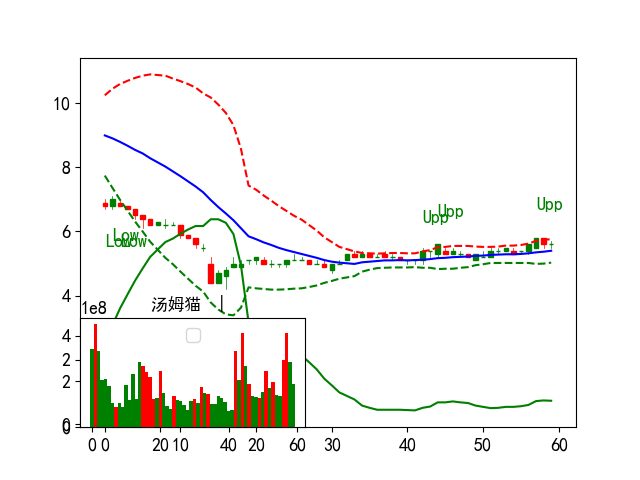

In [65]:
dfNow.loc['300459'][-2:].upper
print(dfsRoot.loc['300459'][-tail_days:].shape)
show_ohlc_upper(dfsRoot.loc['300459'][-tail_days:],code='300459')

In [77]:
# '302132' in dfsRoot.index

False

302132
code:302132 not find in dfsRoot
002384
xratio:-0.03 ra_diff:1.5
code: 002384


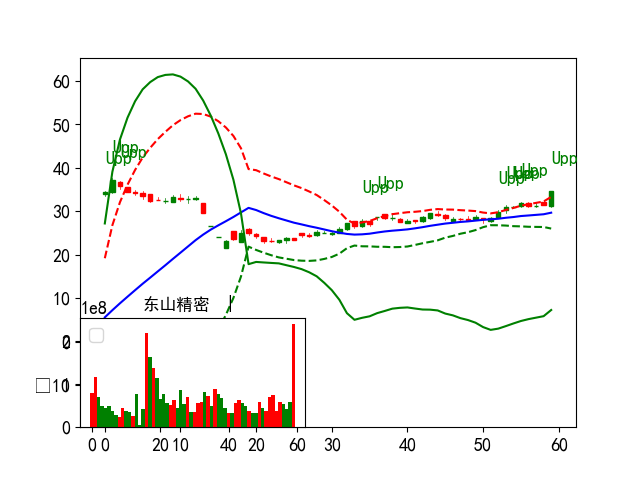

In [76]:
for co in top20_nd.index[:2]:
    print(co)
    # show_ohlc_upper(dfs.loc[co][-30:],co)
    if co in dfsRoot.index:
        show_ohlc_upper(dfsRoot.loc[co][-tail_days:],co)
    else:
        print(f'code:{co} not find in dfsRoot')

In [78]:
code_df = '600519'
dfNow_t2 = dfNow.groupby(level=[0]).tail(2)
# dfNow_f = dfNow_t2[ (dfNow_t2.idx > dfNow_t2.idx.shift(1)) & (dfNow_t2.xratio > dfNow_t2.xratio.shift(1)) ]
idx = pd.IndexSlice
mask_df =  ((dfNow_t2.idx > dfNow_t2.idx.shift(1)) & (dfNow_t2.xratio > dfNow_t2.xratio.shift(1)) )

dfNow_t2 = dfNow_t2.loc[idx[mask_df, :]]

group250 = dfNow_t2.groupby(level=[0])
dfNow_f = group250.tail(1).reset_index().set_index('code')
mask_df = (dfNow_f.date >= cct.get_today())
dfNow_f = dfNow_f.loc[idx[mask_df, :]]
dfNow_f[:2]

date  open  high   low  close         vol        amount  ra_diff  \
code                                                                            
688981 2025-06-16  82.3  83.1  82.2   82.9  12509643.0  1.036016e+09     1.01   
688788 2025-06-16  56.5  57.2  55.0   56.6   2454106.0  1.374985e+08     1.07   

         ma10    ma5  ...  perc5d  vol1d   vol2d  vol3d  vol4d  vol5d  \
code                  ...                                               
688981  83.21  83.06  ...   -2.01 -44.70   46.55 -39.33  32.33   3.18   
688788  55.22  55.14  ...    3.10 -27.52  240.99 -39.36  22.35  -7.05   

        volsum5d  ma51d  xratio  idx  
code                                  
688981      -2.0  83.06   -0.12  0.8  
688788     189.4  55.14   -0.00  1.7  

[2 rows x 32 columns]

In [79]:
# dfNow_f.shape,dfNow_f[:3],dfNow_t2.loc['600812'],df.loc['600812'][-2:]
# dfNow_f[dfNow_f.date >= cct.get_today()]
# dfNow_f.loc['000006']
# dfNow_t2.loc['000006']
# (dfNow_t2.loc[code_df].idx > dfNow_t2.loc[code_df].idx.shift(1)) 
# (dfNow_t2.loc[code_df].xratio > dfNow_t2.loc[code_df].xratio.shift(1))
# dfNow_f.loc[code_df],dfNow.loc[code_df]

### pandas multiinde drop last row

In [80]:
df.loc['000002'][-2:]

open  high  low  close          vol       amount  ra_diff
date                                                                 
2025-06-13   6.5   6.5  6.4    6.4   87615048.0  565615424.0     1.00
2025-06-16   6.5   6.6  6.4    6.6  130234808.0  852638656.0     1.03

In [81]:
dfNow.loc['000002'][-2:]

open  high  low  close          vol       amount  ra_diff  ma10  \
date                                                                          
2025-06-13   6.5   6.5  6.4    6.4   87615048.0  565615424.0     1.00  6.59   
2025-06-16   6.5   6.6  6.4    6.6  130234808.0  852638656.0     1.03  6.58   

             ma5  ma20  ...  perc5d  vol1d  vol2d   vol3d   vol4d  vol5d  \
date                    ...                                                
2025-06-13  6.56  6.66  ...   -3.03 -11.54  -4.89  134.54   -1.90 -11.46   
2025-06-16  6.56  6.65  ...    0.00  48.64 -11.54   -4.89  134.54  -1.90   

            volsum5d  ma51d  xratio  idx  
date                                      
2025-06-13     104.7   6.56   -0.02 -0.3  
2025-06-16     164.8   6.56   -0.02  0.0  

[2 rows x 31 columns]

# 基础处理

In [82]:
# show_tdx_data(dfs.loc['600519'][-2:])
dfs = dfNow.fillna(0)
groupd = dfs.groupby(level=[0])
single = False
dt_low = None
df_idx = None
if single:
    dfs_dtlen = groupd.tail(1)
    print("dfs tail1")
else:
    single = True
    dl = 30
    dindex = tdd.get_tdx_Exp_day_to_df(
        '999999', dl=dl, resample=resample).sort_index(ascending=False)
    dt = tdd.get_duration_price_date('999999', df=dindex)

    dt = dindex[dindex.index >= dt].index.values
    dt_low = dt[-1]
    print('dt_low:%s %s' % (dt_low,dt[0]))
    dtlen = len(dt) if len(dt) > 0 else 1
    dfs_dtlen = groupd.tail(dtlen)
    # import ipdb;ipdb.set_trace()
    dfs_dtlen[-2:]
    df_idx = get_groupby_mean_median_close(dfs_dtlen)

    # print(("dfs tail:%s dt:%s" % (dtlen, dt)))
    dfs_dtlen = get_multi_date_duration(dfs_dtlen, dt[-1])

# groupd2 = dfs.groupby(level=[0])
# dfs['ma%d'%cumdays] = groupd['close'].apply(pd.rolling_mean, cumdays)

# dfs.reset_index().groupby(['code'])['date'].transform('count')
# single = True

print("Low:%s" % (dt[-1]))
# dfs_dtlen.loc['999999'].reset_index().date
lastday_week = dfs_dtlen.loc['999999'].reset_index().date[0]
lastday_week
# dfs_dtlen[('ma%s') % (rollma[-1])][-2:]
# print(df_idx)

dt_low:2025-05-06 2025-06-16


open  high   low  close          vol        amount  \
code   date                                                             
000001 2025-06-13  11.7  11.7  11.6   11.6  109549416.0  1.272773e+09   
       2025-06-16  11.6  11.8  11.5   11.8  117443824.0  1.371042e+09   

                   ra_diff   ma10    ma5   ma20  ...  perc5d  vol1d  vol2d  \
code   date                                      ...                         
000001 2025-06-13     1.08  11.71  11.74  11.58  ...   -0.85   0.08 -23.35   
       2025-06-16     1.10  11.74  11.76  11.60  ...    0.85   7.21   0.08   

                   vol3d  vol4d  vol5d  volsum5d  ma51d  xratio  idx  
code   date                                                           
000001 2025-06-13  84.69  13.32 -41.52      33.2  11.74    0.03  0.1  
       2025-06-16 -23.35  84.69  13.32      81.9  11.76    0.02  0.2  

[2 rows x 31 columns]

Low:2025-05-06


Timestamp('2025-05-06 00:00:00')

In [83]:
time_s = time.time()
# rollma

def get_mask_df(dfs):
    dfs = dfs.fillna(0)
    idx = pd.IndexSlice
    # mask = (dfs[('ma%s')%(rollma[0])] > dfs[('ma%s')%(rollma[1])]) & (dfs[('ma%s')%(rollma[-1])] > 0) & (dfs[('close')] > dfs[('ma%s')%(rollma[0])])  & (dfs[('close')] > dfs[('ma%s')%(rollma[-1])])
    # mask = (dfs[('ma%s')%(rollma[0])] > dfs[('ma%s')%(rollma[1])]) & (dfs[('ma%s')%(rollma[-1])] > 0) & (dfs[('close')] > dfs[('ma%s')%(rollma[1])])  & (dfs[('close')] > dfs[('ma%s')%(rollma[-1])])
    # mask = (dfs[('ma%s')%(rollma[0])] > dfs[('ma%s')%(rollma[1])]) & (dfs[('ma%s')%(rollma[-1])] > 0) &  (dfs[('close')] > dfs[('ma%s')%(rollma[-1])])

    # mask = ( (dfs[('ma%s')%(rollma[0])] > 0) & (dfs[('ma%s')%(rollma[-1])] > 0) & (dfs[('close')] > dfs[('ma%s')%(rollma[-1])]) & (dfs[('close')] > dfs[('ma%s')%(rollma[0])]))
    # mask = ( (dfs[('ma%s')%(rollma[0])] > 0) & (dfs[('ma%s')%(rollma[-1])] > 0)
    #         & (dfs[('close')] > dfs[('ma%s')%(rollma[-1])]*ma_250_l)
    #         & (dfs[('close')] < dfs[('ma%s')%(rollma[-1])]*ma_250_h)
    #         & (dfs[('close')] > dfs[('ma%s')%(rollma[0])]))

    # & (dfs['mean'] > dfs['median'])
    # & (dfs['close'] > dfs['mean'])

    if len(rollma) > 1:

        mask = ((dfs[('ma%s') % (rollma[0])] > 0) & (dfs[('ma%s') % (rollma[-1])] > 0) &
                (dfs[('ma%s') % (rollma[0])] > dfs[('ma%s') % (rollma[-1])]) &
                (dfs[('close')] > dfs[('ma%s') % (rollma[0])]) &
                (dfs[('close')] > dfs[('ma%s') % (rollma[-1])]*ma_250_h) &
                ((dfs[('close')] > dfs['boll']) | (dfs[('close')] > dfs['upper']))
                )
    else:
        mask = ((dfs[('ma%s') % (rollma[0])] > 0) &
                (dfs[('close')] > dfs[('ma%s')%(rollma[0])]) &
                ((dfs[('close')] > dfs['boll']) | (dfs[('close')] > dfs['upper']) )
                )

    return dfs.loc[idx[mask, :]]

# mask = ((dfs[('close')] > dfs[('ma%s')%(rollma[-1])]))


df_mask = get_mask_df(dfs_dtlen)
print(df_mask.shape)
df_mask = get_multi_code_count(df_mask)
print((df_mask.couts[:5], df_mask.shape))

# import ipdb;ipdb.set_trace()
# df.sort_values(by='couts',ascending=0)
# groupd.first()[:2],groupd.last()[:2]
# groupd = df250.groupby(level=[0])
# '''
# groupd.transform(lambda x: x.iloc[-1])
# groupd.last()
# groupd.apply(lambda x: x.close > x.ma250)
# df.shape,df.sort_index(ascending=False)[:5]
# ?groupd.agg
# groupd = df.groupby(level=[0])
# groupd['close'].apply(pd.rolling_mean, 250, min_periods=1)
# ex:# Group df by df.platoon, then apply a rolling mean lambda function to df.casualties
# df.groupby('Platoon')['Casualties'].apply(lambda x:x.rolling(center=False,window=2).mean())

code_uniquelist = df_mask.index.get_level_values('code').unique()
code_select = code_uniquelist[random.randint(0, len(code_uniquelist) - 1)]

# if app:
#     print(round(time.time() - time_s, 2), 's', df.index.get_level_values(
#         'code').unique().shape, code_select, df.loc[code_select][-1:])

if single:
    # groupd = df.groupby(level=[0])
    if tdx:
        # block_path = tdd.get_tdx_dir_blocknew() + '060.blk'
        # if cct.get_work_time():
        #     codew = df[df.date == cct.get_today()].index.tolist()

        if dt_low is not None:

            groupd2 = df_mask.groupby(level=[0])
            df_mask = groupd2.tail(1)
            df_mask = df_mask.reset_index().set_index('code')
            # import ipdb;ipdb.set_trace()

            # df = df[(df.date >= dt_low) & (df.date <= cct.get_today())]
            dd = df_mask[(df_mask.date == dt_low)]
            # df = df[(df_mask.date >= cct.last_tddate(1))]
            df_mask = df_mask[(df_mask.date >= df_mask.date.max())]
            # import ipdb;ipdb.set_trace()
            print(("dt_low:%s df:%s %s df_idx:%s" %
                  (dt_low,len(df_mask), df_mask.index[:5], len(df_idx))))


                
            print(("Main Down dd :%s MainUP df:%s couts std:%0.1f " %
                  (len(dd), len(df_mask), df_mask.couts.std())))
            # print df.date.mode()[0]
            if len(df_mask) > 0:
                if df_idx is not None and len(df_mask) > 0 and len(df_idx) > 0:
                    idx_set_ = [x for x in df_idx.index if x in df_mask.index]
                    # df_mask = df_mask.loc[idx_set_, :].dropna()
                df_mask = df_mask.sort_values(by='couts', ascending=1)
                df_mask = df_mask[df_mask.couts > df_mask.couts.std()]
            else:
                print("df_mask is None:%s"%(len(df_mask)))
            # df = df[(df.date >= df.date.mode()[0]) & (df.date <= cct.get_today())]
            codew = df_mask.index.tolist()

            if app:
                print(
                    "time: %s  %s" %
                    (round(time.time() - time_s, 2), len(df_mask)))

        else:
            df_mask = df_mask.reset_index().set_index('code')
            df_mask = df_mask[(df_mask.date >= cct.last_tddate(days=10)) &
                              (df_mask.date <= cct.get_today())]
            codew = df_mask.index.tolist()

        top_temp = tdd.get_sina_datadf_cnamedf(codew, df_mask)
  #      top_temp = top_temp[(~top_temp.index.str.contains(
  #          '688')) & (~top_temp.name.str.contains('ST'))]
        top_temp = top_temp.sort_values(by=['couts'], ascending=[0])
        codew = top_temp.index.tolist()

        # clean st and 688

    # df['date'] = df['date'].apply(lambda x:(x.replace('-','')))
    # df['date'] = df['date'].astype(int)
    # print df_mask.loc[code_select].T,df_mask.shape
#     MultiIndex = False
# else:
#     MultiIndex = True

(19231, 31)
count dd.couts
(code    date      
603699  2025-05-06    27
603393  2025-05-06    27
603259  2025-05-06    27
603699  2025-05-07    27
603393  2025-05-07    27
Name: couts, dtype: int64, (19231, 32))
dt_low:2025-05-06 df:598 Index(['603259', '601838', '601717', '600259', '600216'], dtype='object', name='code') df_idx:1455
Main Down dd :2 MainUP df:598 couts std:6.2 
time: 0.08  505


In [84]:
dfs_dtlen.loc['002987'][-1:]

open  high   low  close         vol        amount  ra_diff   ma10  \
date                                                                            
2025-06-16  13.8  14.6  13.8   14.6  73126880.0  1.055929e+09     1.21  14.53   

             ma5   ma20  ...  perc5d   vol1d  vol2d  vol3d  vol4d  vol5d  \
date                     ...                                               
2025-06-16  14.3  13.57  ...   -1.35  132.64  -9.65 -24.49  -9.48 -22.52   

            volsum5d  ma51d  xratio  idx  
date                                      
2025-06-16      66.5   14.3   -0.11  0.2  

[1 rows x 31 columns]

## 最近60天筛选

In [85]:
# 截取最后5天数据
dfs_tail = dfs.groupby(level=[0]).tail(tail_days)
# 还原多索引
# dfs_tail = dfs_tail.reset_index().set_index(['code','date'])
# dfs_tail[dfs_tail.ra_diff > 2]

### filter mask250 get_level_values

In [86]:
mask250 = ((dfs_tail[('ma%s') % (rollma[0])] > 0) & (dfs_tail[('ma%s') % (rollma[-1])] > 0) &
           (dfs_tail[('close')] > dfs_tail[('ma%s') % (rollma[0])])
            & (dfs_tail[('close')] > dfs_tail[('ma%s') % (rollma[-1])]*1.03)
              & (dfs_tail[('close')] < dfs_tail[('ma%s') % (rollma[-1])]*1.1)
                & (dfs_tail[('close')] > dfs_tail[('ma20')])
           & (dfs_tail[('close')] < dfs_tail[('ma20'   )]*1.1))
idx = pd.IndexSlice
df_mask250 = dfs_tail.loc[idx[mask250, :]]
print(df_mask250.shape)
df_mask250 = get_multi_code_count(df_mask250)
print((df_mask250.couts[:1], df_mask250.shape))

groupd250 = df_mask250.groupby(level=[0])
df_mask250 = groupd250.tail(1)
# df_mask250 = df_mask250[df_mask250.index.get_level_values(1) > str(df_mask250.loc['999999'].index[0])[:10] ]
# df_mask250 = clean_688(df_mask250)

# df_mask250['idx'] = df_idx_detect
print((df_mask250.couts[:2], df_mask250.shape))
# print(df_mask.loc['002987'])
df_mask250 = df_mask250.sort_values(
        by=['ra_diff','hat', 'couts'],
        ascending=[0,0, 0])
show_tdx_data(
    df_mask250)[:3]

(1081, 31)
count dd.couts
(code    date      
002983  2025-04-29    19
Name: couts, dtype: int64, (1081, 32))
(code    date      
002983  2025-06-11    19
001378  2025-06-11    14
Name: couts, dtype: int64, (307, 32))
Count:307 32


couts  ra_diff  xratio  idx    hat  close  volsum5d  hmax  \
code   date                                                                    
688313 2025-05-19      2     2.25     0.0  0.0  19.88   31.1       3.6  33.3   
300871 2025-05-19      3     1.93     0.0  0.0   4.10   23.5     135.4  26.4   
300845 2025-05-14      1     1.72     0.0  0.0   5.09   17.7     294.5  17.7   

                   lmin  perc1d   ma20  ma250   vol1d  vol2d   vol3d  vol4d  \
code   date                                                                   
688313 2025-05-19  14.9   -1.27  29.60  30.03  -17.23  39.23  -34.07  39.92   
300871 2025-05-19  20.7   -1.26  22.08  22.07  -33.46 -26.96  108.70  59.45   
300845 2025-05-14  11.8   19.59  16.70  17.11  187.52  48.86   54.90  15.69   

                   vol5d  perc3d  perc5d  
code   date                               
688313 2025-05-19 -24.20    4.71    7.24  
300871 2025-05-19  27.68    3.07    5.38  
300845 2025-05-14 -12.42   27.34   31.11

#### filter today

In [87]:
df_mask250  = df_mask250[(df_mask250.xratio > 0) & (df_mask250.index.get_level_values('date') > cct.get_today() )]
# df_tail1[df_tail1.index.get_level_values('date') == cct.get_today()].shape


In [88]:
# df_mask250.index.get_level_values(1) > str(df_mask250.loc['999999'].index[0])[:10]

#### debug ra_diff4

In [89]:
dfs.loc['301073'][-5:].ra_diff

date
2025-06-09    1.15
2025-06-10    1.16
2025-06-11    1.19
2025-06-13    1.11
2025-06-16    1.11
Name: ra_diff, dtype: float64

xratio:-0.01 ra_diff:1.03
code: 000002


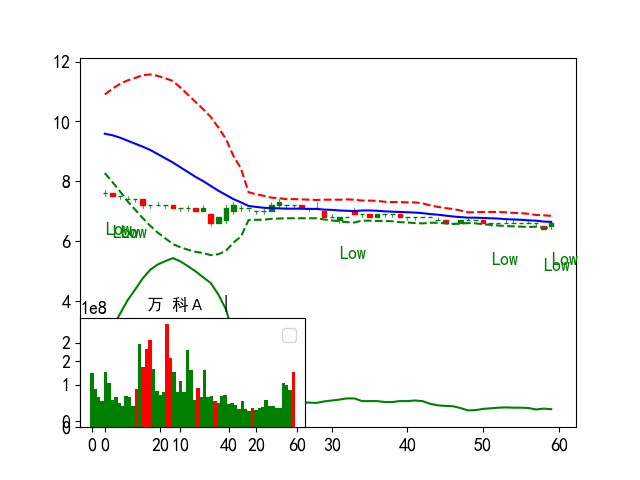

In [90]:
# dfs.loc['000002'][-60:]
show_ohlc_upper(dfsRoot.loc['000002'][-60:],code='000002')
for co in df_mask250.index.get_level_values(0)[:10]:
    print(co,dfs.loc[co].ra_diff[-1])
    show_ohlc_upper(dfsRoot.loc[co][-tail_days:],code=co)

## 最近60天数据

In [91]:
dfs_tail9 = dfs.groupby(level=[0]).tail(tail_days)

# 提取倒数第二天
# dfs_tail9 = dfs.groupby(level=[0]).tail(6)
# dfs_tail9 = dfs_tail9[dfs_tail9.index.get_level_values(1) <lastday]


# dfs_tail9.index.get_level_values(0)
# 还原多索引
# dfs_tail = dfs_tail.reset_index().set_index(['code','date'])
# print(dfs_tail9.loc['002987'][:1])
# show_tdx_data(dfs_tail9.loc[code_t])
# dfs_tail9=compute_perd_value(dfs_tail9,market_value=5,col='vol')

# show_tdx_data(dfs_tail9.loc[code_t])
# print((dfs_tail9.loc[code_t]))

In [92]:
dfs_tail9.loc[(['999999','399001','399006'],'ra_diff')].groupby(level=0).tail(3)
# dfs_tail9.loc[pd.IndexSlice[['999999','399001','399006'], :, :]].tail(3)
# dfs_tail9.query(("code == '999999'" and "date > '2023-04-01'"))

code    date      
999999  2025-06-11    1.10
        2025-06-13    1.09
        2025-06-16    1.09
399001  2025-06-11    1.09
        2025-06-13    1.08
        2025-06-16    1.08
399006  2025-06-11    1.14
        2025-06-13    1.13
        2025-06-16    1.14
Name: ra_diff, dtype: float64

## 超跌反弹年线大于MA20

In [93]:
# show_tdx_data(dfs_tail9.loc['300418'])[-2:]
show_tdx_data(dfs_tail9.loc['603131'])[-2:]
# print(dfs_tail9.loc['603131',['high','upper','hmax']])

Count:30 31


ra_diff  xratio  idx   hat  close  volsum5d  hmax  lmin  perc1d  \
date                                                                          
2025-06-13     1.11    0.01 -0.1  1.90   17.0     -19.3  18.6  16.4   -3.41   
2025-06-16     1.12    0.01  0.0  1.89   17.1     -44.1  18.6  16.4    0.59   

             ma20  ma250  vol1d  vol2d  vol3d  vol4d  vol5d  perc3d  perc5d  
date                                                                         
2025-06-13  17.16  13.31  -3.28 -53.01  98.46 -37.26 -24.24   -3.95   -6.59  
2025-06-16  17.17  13.32 -49.06  -3.28 -53.01  98.46 -37.26   -3.39   -5.00

## !!! Run-Filter强势Upper

### !!! filterRule test

In [94]:
# dfs_tail9.loc['002722']


def rules_to_list(rules):
    rules_l = (rules).split('&')
    for l in rules_l:
        print(l)
    return rules_l


def filter_rule_Test(dfs_tail9,resample=resample):
    col_rule = ["(dfs_tail9[('close')] > dfs_tail9[('ma5')])",
                "(dfs_tail9[('high')] > dfs_tail9.upper)",
                "(dfs_tail9[('ma5')] > dfs_tail9[('ma20')])"]
    col_rule2 = [
        "(dfs_tail9[('close')] > dfs_tail9[('hmax')].shift(1)*0.98) | (dfs_tail9['close'] > dfs_tail9['hmax']*0.97)",
        "((dfs_tail9[('vol1d')] > 0) | (dfs_tail9.close > dfs_tail9.close.shift(1)*0.99))"]
    col_rule3 = [
        "((dfs_tail9[('vol2d')] > 0) | (dfs_tail9.close.shift(1) > dfs_tail9.close.shift(2)*0.99))"]

    col_rule_tail1 = ["(dfs_tail9.perc1d < 21)", "(dfs_tail9.perc2d > 0)"]
    if resample.upper()=='D':
        col_rule_tail2 = [
            "((dfs_tail9.perc3d > 0) | ((dfs_tail9.close.shift(2) > dfs_tail9.ma5.shift(2))) )",
            "((dfs_tail9.volsum5d > 50) )",
            "(dfs_tail9['close'] > dfs_tail9[('hmax')])",
            "(dfs_tail9[('close')] > dfs_tail9[('ma250')])",
            "(dfs_tail9['low'] > dfs_tail9[('low')].shift(1))"]
        col_rule_tail3 = ["(dfs_tail9[('hmax')] > 0)",
                 "(dfs_tail9[('high')] >= dfs_tail9[('hmax')])",
                 "(dfs_tail9[('close')] > dfs_tail9.ma250 * 0.99)"]
    else:
        col_rule_tail2 = [
            "((dfs_tail9.perc3d > 0) | ((dfs_tail9.close.shift(2) > dfs_tail9.ma5.shift(2))) )",
            "((dfs_tail9.volsum5d > 50) )",
            "(dfs_tail9['close'] > dfs_tail9[('hmax')])",
            "(dfs_tail9['low'] > dfs_tail9[('low')].shift(1))"]
        col_rule_tail3 = ["(dfs_tail9[('hmax')] > 0)",
                 "(dfs_tail9[('high')] >= dfs_tail9[('hmax')])"]
    col_rule_tail4=[ "(dfs_tail9[('xratio')] > dfs_tail9[('xratio')].shift(1))",
             "(dfs_tail9[('xratio')].shift(1) > dfs_tail9[('xratio')].shift(2))"]
    
    col_rule.extend(col_rule2)
    col_rule.extend(col_rule3)
    col_rule.extend(col_rule_tail1)
    col_rule.extend(col_rule_tail2)
    col_rule.extend(col_rule_tail3)
    col_rule.extend(col_rule_tail4)
    
    for co in col_rule:
        print("%s:%s" % (co, eval(co)), end='')



30
9 -0.02 -0.2


'Bear'

-0.2

date
2025-06-09    0.01
2025-06-10    0.01
2025-06-11    0.01
2025-06-13    0.00
2025-06-16    0.00
Name: xratio, dtype: float64

xratio:0.0 ra_diff:1.04
code: 601728


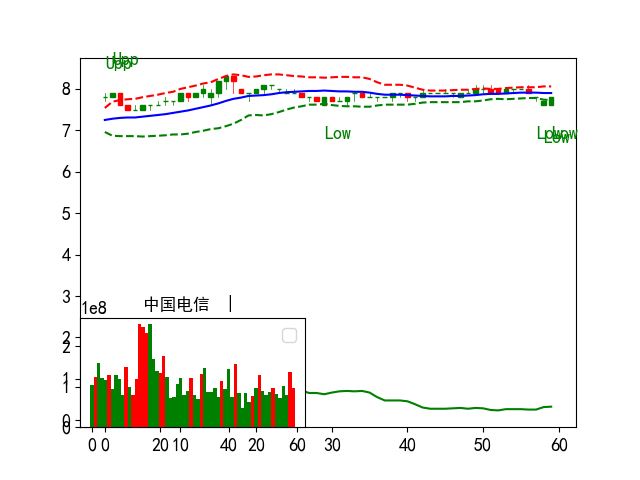

In [95]:
code_filter = '601728'

print(len(dfs_tail9.loc[code_filter]))

# show_tdx_data(dfs_tail9.loc[code_filter])
detect_bull_bear(dfs.loc[code_filter][-120:].close)
detect_bull_bear_apply(dfs.loc[code_filter][-120:].close)

dfs.loc[code_filter].xratio[-5:]

# filter_rule_Test(dfs_tail9.loc[code_filter])

show_ohlc_upper(dfsRoot.loc[code_filter][-60:], code=code_filter)



In [96]:
# dfs.loc['300474'][-5:]

### 新高Hmax日见新高df_mask_hmax

#### hmax 追高 TEST

30
xratio:0.02 ra_diff:1.12
code: 600012


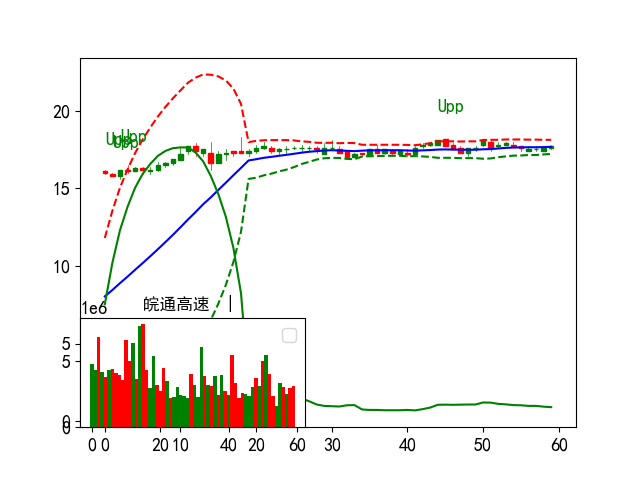

In [97]:
code='600012'
print(len(dfs_tail9.loc[code]))
# show_tdx_data(dfs_tail9.loc[code],col='upper')
show_ohlc_upper(dfsRoot.loc[code],code=code)

In [98]:

# mask_hmax = ((dfs_tail9[('close')] > dfs_tail9[('hmax')].shift(
#     1) * 0.99) | (dfs_tail9['close'] > dfs_tail9['hmax'] * 0.99))

# mask_hmax = ( (dfs_tail9[('hmax')] > 0) & ((dfs_tail9[('high')] > dfs_tail9[('hmax')].shift(
#     1) * 0.99) | (dfs_tail9['high'] > dfs_tail9['hmax'] * 0.99)) )

# mask_hmax = ((dfs_tail9[('hmax')] > 0) &

if resample.upper() =='D':
    mask_hmax = ( (dfs_tail9[('high')] > dfs_tail9[('hmax')].shift(1)) &
                 ((dfs_tail9[('high')] >= dfs_tail9[('hmax')])) &
                 (dfs_tail9[('close')] > dfs_tail9.ma250 * 0.99))
                 # (dfs_tail9[('close')] > dfs_tail9.ma250 * 0.99) &
                 # (dfs_tail9[('close')] < dfs_tail9.ma250 * 1.05))
else:
    mask_hmax = ( (dfs_tail9[('low')] >= dfs_tail9[('ma5')].shift(1))  &
              (dfs_tail9[('high')] >= dfs_tail9[('high')].shift(1))  ) 

# mask_hmax = ( (dfs_tail9[('hmax')] > 0) & (dfs_tail9[('close')] > dfs_tail9.ma20 *0.99) & (dfs_tail9[('close')] < dfs_tail9.ma20 *1.20) )


df_mask_hmax = dfs_tail9.loc[idx[mask_hmax, :]]
df_mask_hmax = get_multi_code_count(df_mask_hmax)

# df_mask_hmax = df_mask_hmax[ (df_mask_hmax[('close')] > df_mask_hmax.upper)]

# df_mask_hmax.couts.std()

df_mask_hmax = df_mask_hmax.groupby(level=[0]).tail(
    1).reset_index().set_index('code')

df_mask_hmax = df_mask_hmax[df_mask_hmax.date >= lastday]
# df_mask_hmax = get_sina_data_cname(df_mask_hmax, dm,realtime=True)
df_mask_hmax = get_sina_data_cname(df_mask_hmax, realtime=True)

df_mask_hmax = clean_688(df_mask_hmax)

# show_tdx_data(df_mask_hmax[df_mask_hmax.couts == 9])

# by=['perc', 'perc5d', 'perc1d'],
# code_t = '000534'
df_mask_hmax = df_mask_hmax.sort_values(
    by=['couts','volsum5d', 'idx', 'hat', 'perc1d'],ascending=[0,0, 0, 0, 0])
    # by=['volsum5d', 'idx', 'hat', 'perc1d'],ascending=[0, 0, 0, 0])
# print(df_mask_hmax.couts[:1], df_mask_hmax.shape)
# show_tdx_data(df_mask_hmax.loc['300461'])
df_mask_hmax.couts[:1], df_mask_hmax.shape
show_tdx_data(df_mask_hmax)[:10]
# show_tdx_data(df_mask_hmax[(df_mask_hmax.couts > 1) & (df_mask_hmax.volsum5d > 10) & (df_mask_hmax.volsum5d < 150)]).T

count dd.couts
compute percent


(code
 002134    14
 Name: couts, dtype: int64,
 (291, 41))

Count:291 41


name  couts       date   perc  ra_diff  xratio   idx    hat  close  \
code                                                                         
002134  天津普林     14 2025-06-16   4.03     1.70    0.33   3.1   9.24   25.8   
300689  澄天伟业     13 2025-06-13  -9.95     2.19    0.46  20.7  20.70   51.6   
301338  凯格精机     13 2025-06-16   5.68     1.46    0.10   3.8   3.84   40.9   
000766  通化金马     13 2025-06-16   9.96     1.64    0.29   7.3   9.27   27.6   
300920  润阳科技     13 2025-06-16  11.04     2.94    0.85  12.6  25.31   53.3   
300204   舒泰神     13 2025-06-16   5.69     6.19    1.35  12.5  36.97   39.0   
300832   新产业     11 2025-06-13  -3.80     1.21    0.45   1.7  10.85   58.2   
002384  东山精密     11 2025-06-16   9.84     1.50    0.19   6.4   7.29   34.6   
301080  百普赛斯     11 2025-06-13  -0.68     1.47    0.37   6.2  10.26   58.4   
603129  春风动力     11 2025-06-16  -4.22     1.51    1.59  28.8  56.76  211.2   

        volsum5d  ...  ma250  nclose   llow   vol1d   vol2d  vol3d  vol4d  \
code              ...                                                       
002134     -21.3  ...  11.21    25.0   24.3   49.19   10.49 -43.84 -19.29   
300689     324.2  ...  20.87    51.7   46.7   64.42  198.97 -11.85   7.57   
301338     150.1  ...  32.27    40.4   38.4  149.14   -1.02 -30.84  52.88   
000766     106.0  ...  15.75    27.4   25.5   49.16    4.92  15.28 -12.75   
300920      20.1  ...  24.82    52.9   48.1   61.66  -35.86  16.57   4.95   
300204     -24.6  ...  13.54    37.0   34.6  -16.95   10.52 -28.51 -10.97   
300832     467.8  ...  37.29    58.5   59.1  503.44  -50.16  -1.51  13.94   
002384     373.5  ...  11.33    34.3   31.0  307.58   39.17 -20.15 -10.31   
301080     147.4  ...  24.38    58.2   58.6   79.09  -47.35  29.74  99.71   
603129     121.5  ...  53.78   212.1  208.4   29.52   43.38 -32.00  94.98   

        vol5d  perc3d  perc5d  
code                           
002134 -17.83    3.20    8.40  
300689  65.08   45.06   50.00  
301338 -20.03    5.68    4.60  
000766  49.34   13.11   18.97  
300920 -27.19   14.38   13.40  
300204  21.28   22.26   34.02  
300832   2.13   -3.66   -1.79  
002384  57.22   10.90   11.25  
301080 -13.82    6.52    8.49  
603129 -14.34    1.15    7.70  

[10 rows x 24 columns]

#### !!! hmax Top upper > 1

In [99]:
# dfs_tail9.loc['600103']

In [100]:
# mask_hmax = ((dfs_tail9[('close')] > dfs_tail9[('hmax')].shift(
#     1) * 0.99) | (dfs_tail9['close'] > dfs_tail9['hmax'] * 0.99))

# mask_hmax = ( (dfs_tail9[('hmax')] > 0) & ((dfs_tail9[('high')] > dfs_tail9[('hmax')].shift(
#     1) * 0.99) | (dfs_tail9['high'] > dfs_tail9['hmax'] * 0.99)) )

# mask_hmax = ( (dfs_tail9[('hmax')] > 0) & ((dfs_tail9[('high')] >= dfs_tail9[('hmax')]*0.99) ) )
# mask_hmax = (  (dfs_tail9[('high')] >= dfs_tail9[('hmax')]*0.99) )
if resample.upper() == 'D':
    mask_hmax = (  (dfs_tail9[('high')] >= dfs_tail9[('high')].shift(1)) & 
                 (dfs_tail9[('high')].shift(1) >= dfs_tail9[('high')].shift(2)) &
                (dfs_tail9[('high')] >= dfs_tail9[('hmax')]*0.99) &
                (dfs_tail9[('close')] >= dfs_tail9[('upper')].shift(1)) )
else:
    mask_hmax = (  (dfs_tail9[('high')] >= dfs_tail9[('high')].shift(1)) & 
                 (dfs_tail9[('high')].shift(1) >= dfs_tail9[('high')].shift(2)) &
                (dfs_tail9[('close')] >= dfs_tail9[('upper')].shift(1)) )

df_mask_hmax = dfs_tail9.loc[idx[mask_hmax, :]]

#站上Upper
# df_mask_hmax = df_mask_hmax[ (df_mask_hmax[('close')] > df_mask_hmax.upper)]

df_mask_hmax = get_multi_code_count(df_mask_hmax)
df_mask_hmax = df_mask_hmax.groupby(level=[0]).tail(
    1).reset_index().set_index('code')



df_mask_hmax = df_mask_hmax[df_mask_hmax.date >= lastday]
# df_mask_hmax = get_sina_data_cname(df_mask_hmax, dm,realtime=True)
df_mask_hmax = get_sina_data_cname(df_mask_hmax, realtime=True)

df_mask_hmax = clean_688(df_mask_hmax)

# show_tdx_data(df_mask_hmax[df_mask_hmax.couts == 9])

# by=['perc', 'perc5d', 'perc1d'],
# code_t = '000534'
df_mask_hmax = df_mask_hmax.sort_values(
    by=['couts', 'idx', 'hat', 'perc1d'],
    ascending=[0, 0, 0, 0])
 # by=['volsum5d', 'idx', 'hat', 'perc1d'],
print(df_mask_hmax.couts[:1], df_mask_hmax.shape)
# show_tdx_data(df_mask_hmax.loc['000039'])
df_mask_hmax.couts[:1], df_mask_hmax.shape

# show_tdx_data(df_mask_hmax).T
# show_tdx_data(df_mask_hmax[(df_mask_hmax.couts > 1) & (df_mask_hmax.volsum5d > 10) & (df_mask_hmax.volsum5d < 150)])
show_tdx_data(df_mask_hmax.query('couts >= 1 and perc >2  and   low < ma5 ') )[:10]

count dd.couts
compute percent
code
001203    14
Name: couts, dtype: int64 (412, 41)


(code
 001203    14
 Name: couts, dtype: int64,
 (412, 41))

Count:81 41


name  couts       date   perc  ra_diff  xratio  idx    hat  close  \
code                                                                         
601860   紫金银行     10 2025-06-16   3.45     1.15    0.01  0.1   0.27    3.0   
600000   浦发银行      9 2025-06-16   2.44     1.31    0.02  0.3   0.59   12.6   
603883    老百姓      8 2025-06-16   7.66     1.31    0.11  3.3   5.26   22.5   
600846   同济科技      8 2025-06-16   5.77     1.36    0.05  1.5   1.97   11.0   
603336   宏辉果蔬      8 2025-06-16  11.29     1.53    0.05  1.4   1.61    6.9   
002734   利民股份      7 2025-06-16  10.19     2.32    0.38  4.6  10.35   22.7   
000929  *ST兰黄      7 2025-06-16   4.71     1.53    0.07  0.5   1.82    8.9   
000802   北京文化      7 2025-06-16   4.26     1.20    0.02  0.3   0.57    4.9   
603083   剑桥科技      6 2025-06-16   2.90     1.51    0.21  9.7  14.11   46.2   
603226   菲林格尔      6 2025-06-13   5.56     2.00    0.14  3.1   5.67   11.4   

        volsum5d  ...  ma250  nclose  llow   vol1d   vol2d  vol3d  vol4d  \
code              ...                                                      
601860      35.3  ...   6.99     2.9   2.9   -3.29   49.22 -48.08  31.70   
600000      30.2  ...  12.12    12.4  12.2  -17.40   40.19 -11.56 -11.84   
603883      63.7  ...  16.44    22.6  21.1   90.83   27.00  13.85 -31.27   
600846      97.9  ...  12.77    11.0  10.4   22.50   88.09 -44.28 -10.29   
603336     242.0  ...  25.40     6.6   6.2  238.55   25.61 -10.30 -11.08   
002734      59.5  ...  14.07    21.5  19.5   -7.43   35.14  40.97  11.83   
000929      96.8  ...   6.09     8.8   8.4   69.95    3.15   2.83  72.81   
000802      94.5  ...   9.37     4.9   4.7   -6.08   55.75 -15.98   2.39   
603083     -57.0  ...  25.48    46.7  44.4    1.11   31.64 -20.82 -38.18   
603226     364.7  ...  13.94    11.5  10.8  -36.72  411.89 -37.30 -45.64   

        vol5d  perc3d  perc5d  
code                           
601860   5.79    3.45    3.45  
600000  30.85    1.61    2.44  
603883 -36.70    4.17    5.14  
600846  41.88    5.77   10.00  
603336  -0.82   15.00   16.95  
002734 -20.97   10.73   14.07  
000929 -51.93    5.95    4.71  
000802  58.47    2.08    4.26  
603083 -30.70    4.76    2.44  
603226  72.49    9.09   31.71  

[10 rows x 24 columns]

In [101]:
# show_tdx_data(df_mask_hmax.loc['600103'][-5:])

##### sort_values

In [102]:
show_tdx_data(
    df_mask_hmax.query('perc > 1').sort_values(
        by=['ra_diff', 'couts', 'idx'],
        ascending=[0, 0, 0]),col='ra_diff')[:20]

Count:247 41


name  couts       date   perc  ra_diff  ra_diff  xratio   idx    hat  \
code                                                                           
002365  永安药业      7 2025-06-16   7.14     3.29     3.29    0.54   7.0  13.41   
002826  易明医药     10 2025-06-16   4.00     2.60     2.60    0.47  11.5  16.62   
300546  雄帝科技      6 2025-06-16  13.89     2.60     2.60    0.80  11.9  25.68   
600281  华阳新材      6 2025-06-16   5.48     2.48     2.48    0.06   2.9   2.94   
300468  四方精创      4 2025-06-16  19.93     2.40     2.40    0.67  11.9  23.01   
603657  春光科技      8 2025-06-16   1.52     2.36     2.36    0.33  11.8  16.62   
002940   昂利康     10 2025-06-16  10.27     2.34     2.34    0.57  13.9  19.50   
002734  利民股份      7 2025-06-16  10.19     2.32     2.32    0.38   4.6  10.35   
002878  元隆雅图      7 2025-06-16  10.04     2.25     2.25    0.39   8.2  13.56   
300581  晨曦航空      6 2025-06-16   7.59     2.12     2.12   -0.10   3.6   4.23   
300157  新锦动力      2 2025-06-16   8.51     2.12     2.12    0.03   1.5   1.45   
300548  博创科技      4 2025-06-16   3.65     2.09     2.09    0.36  14.9  18.35   
002731  萃华珠宝      7 2025-06-16  10.19     2.06     2.06    0.24   5.6   7.35   
002104  恒宝股份      7 2025-06-16  10.66     2.01     2.01    0.23   4.6   8.29   
603226  菲林格尔      6 2025-06-13   5.56     2.00     2.00    0.14   3.1   5.67   
000701  厦门信达      4 2025-06-16   6.58     1.98     1.98    0.10   2.6   3.50   
300485  赛升药业      6 2025-06-13   1.46     1.93     1.93    0.20   3.5   6.09   
300798  锦鸡股份      6 2025-06-16   6.25     1.92     1.92    0.15   4.6   6.06   
600980  北矿科技      5 2025-06-16   5.45     1.88     1.88    0.32  12.4  14.66   
300773   拉卡拉      4 2025-06-16  15.19     1.88     1.88    0.20   2.7   9.74   

        close  ...  ma250  nclose  llow    vol1d   vol2d   vol3d   vol4d  \
code           ...                                                         
002365   27.0  ...  12.45    27.5  25.3   125.62  -42.78   -4.76   -4.17   
002826   23.4  ...  16.78    22.9  22.1   -21.97  495.15   33.34  558.99   
300546   36.9  ...  27.45    34.9  32.9    20.94  -25.49   18.96   19.27   
600281    7.7  ...   7.11     7.0   6.6    10.90  193.64  -40.40   -8.11   
300468   36.7  ...  23.60    34.6  32.1     4.28   -3.86   -0.01   37.89   
603657   33.5  ...  21.35    33.5  32.2     5.92  -12.95  -11.24  -20.02   
002940   29.0  ...  16.68    28.1  25.7    -5.74  -43.82  460.04  -40.77   
002734   22.7  ...  14.07    21.5  19.5    -7.43   35.14   40.97   11.83   
002878   27.4  ...  26.42    27.3  25.0   -26.96   43.52   -3.69   16.72   
300581   17.0  ...  17.00    17.0  16.3    10.24  371.81  -52.91  -13.86   
300157    5.1  ...   4.64     5.2   5.0    47.40  502.73  -44.68   -6.16   
300548   62.4  ...  21.10    63.0  60.5   -19.97  141.69  -33.39  -28.94   
002731   17.3  ...  14.44    17.3  15.6    27.72  -27.21   28.56  -23.49   
002104   13.5  ...   7.82    13.4  12.6    -7.62   12.72   -8.98   -0.18   
603226   11.4  ...  13.94    11.5  10.8   -36.72  411.89  -37.30  -45.64   
000701    8.1  ...   6.54     7.8   7.1    -2.26   63.10  -11.99   -2.80   
300485   13.9  ...  25.01    13.6  12.5   -16.78   70.67   68.39   71.41   
300798   11.9  ...  14.80    11.8  11.0   -18.28    3.74  -11.05   47.97   
600980   29.0  ...   8.37    28.8  26.8  2080.90  -82.22  678.23  -84.81   
300773   27.3  ...  28.38    25.7  23.8    59.31   11.93    3.35   22.46   

         vol5d  perc3d  perc5d  
code                            
002365    8.56   17.90   35.00  
002826  -35.92   19.39   44.44  
300546  -13.72   31.79   41.92  
600281   99.13   42.59   50.98  
300468  -20.07   29.68   33.45  
603657  -10.55   13.56   20.50  
002940  -45.06   22.36   47.96  
002734  -20.97   10.73   14.07  
002878    8.01   46.52   56.57  
300581  -26.97   26.87   22.30  
300157  -18.13   30.77   30.77  
300548   -3.07   15.99   12.64  
002731  -29.67   30.08   24.46  
002104   -7.96   21.62   22.73  
603226   72.49    9.09   31.71  
000701  141.7

xratio:-0.04 ra_diff:1.0
code: 300540


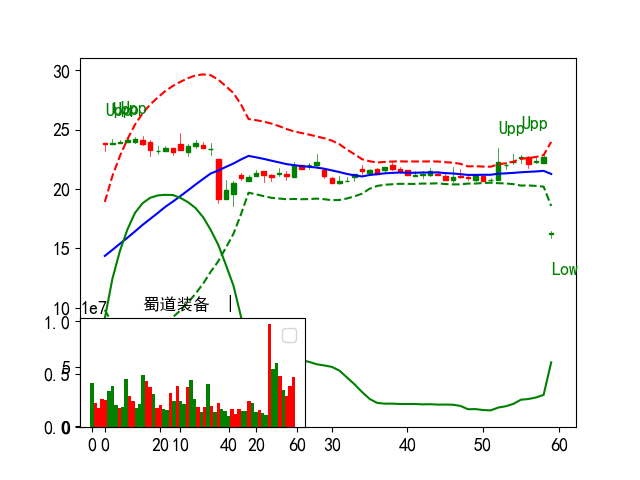

In [103]:
show_ohlc_upper(dfsRoot.loc['300540'][-60:],code='300540')

### !!! df_mask250 upper xratio

In [104]:

if resample.upper() =='D':
    mask250 = ((dfs_tail9[('high')] > dfs_tail9.upper) &
               (dfs_tail9[('close')] > dfs_tail9[('ma5')])
               & (dfs_tail9[('ma5')] > dfs_tail9[('ma20')])
               & ((dfs_tail9[('vol1d')] > 0) | (dfs_tail9.close > dfs_tail9.close.shift( 1)*0.99))
               & ((dfs_tail9[('vol2d')] > 0) | (dfs_tail9.close.shift(1) > dfs_tail9.close.shift(2)*0.99))
               & (dfs_tail9['close'] > dfs_tail9[('hmax')]) &
                (dfs_tail9[('close')] > dfs_tail9[('ma250')]) | ((dfs_tail9[('high')] > dfs_tail9.upper) &
                                                                 (dfs_tail9[('close')] > dfs_tail9[('ma5')])) &
               (dfs_tail9[('ma5')] > dfs_tail9[('ma20')])
               & ((dfs_tail9[('vol1d')] > 0) | (dfs_tail9.close > dfs_tail9.close.shift(1)*0.99))
               & ((dfs_tail9[('vol2d')] > 0) | (dfs_tail9.close.shift(1) > dfs_tail9.close.shift(2)*0.99))
               & (dfs_tail9['low'] > dfs_tail9[('low')].shift(1))
               & (dfs_tail9[('close')] > dfs_tail9[('ma250')])
               & (dfs_tail9[('xratio')] > dfs_tail9[('xratio')].shift(1))
               & (dfs_tail9[('xratio')].shift(1) > dfs_tail9[('xratio')].shift(2))
              )
elif resample.upper() =='W' or resample == 'W-FRI':
    mask250 = (
               (dfs_tail9[('close')] > dfs_tail9[('ma5')])
               & (dfs_tail9[('ma5')] > dfs_tail9[('ma20')])
               & ((dfs_tail9[('vol1d')] > 0) | (dfs_tail9.close > dfs_tail9.close.shift(1)*0.99))
               & ((dfs_tail9[('vol2d')] > 0) | (dfs_tail9.close.shift(1) > dfs_tail9.close.shift(2)*0.99))
               & (dfs_tail9['low'] > dfs_tail9[('low')].shift(1))
               & (dfs_tail9[('xratio')] > dfs_tail9[('xratio')].shift(1))
               & (dfs_tail9[('xratio')].shift(1) > dfs_tail9[('xratio')].shift(2))
              )
else:
    mask250 = (
               (dfs_tail9[('close')] > dfs_tail9[('ma5')])
               & (dfs_tail9[('ma5')] > dfs_tail9[('ma20')])
               & ((dfs_tail9[('vol1d')] > 0) | (dfs_tail9.close > dfs_tail9.close.shift(1)*0.99))
               & ((dfs_tail9[('vol2d')] > 0) | (dfs_tail9.close.shift(1) > dfs_tail9.close.shift(2)*0.99))
               & (dfs_tail9['low'] > dfs_tail9[('low')].shift(1))
              )

# & (dfs_tail9[('close')] < dfs_tail9[('ma20'  )]*1.1))
idx = pd.IndexSlice
df_mask250 = dfs_tail9.loc[idx[mask250, :]]
df_mask250.shape
#站上Upper
df_mask250 = df_mask250[ (df_mask250[('close')] > df_mask250.upper)]

df_mask250 = get_multi_code_count(df_mask250)


code_t = '603131'
print((df_mask250.couts[:3], df_mask250.shape))
# df_mask250.loc[code_t]
groupd250 = df_mask250.groupby(level=[0])
df_mask250 = groupd250.tail(1).reset_index().set_index('code')
# df_mask250 = get_sina_data_cname(df_mask250, dm,realtime=True)



# df_mask250.loc[code_t].close
df_mask250 = get_sina_data_cname(df_mask250, realtime=True)
# df_mask250.loc[code_t].close

df_mask250 = clean_688(df_mask250)
# df_masklastd.loc['002722']

df_mask250 = df_mask250.sort_values(
    by=['idx','xratio',  'hat', 'perc1d'],
    ascending=[0, 0, 0, 0])
    # by=['xratio', 'idx', 'hat', 'perc1d'],

# by=['perc', 'perc5d', 'perc1d'],
# ascending=[0, 0, 0])
print("df_mask250:%s df_mask_hmax:%s"%(len(df_mask250),len(df_mask_hmax)))
cross_hmax_250 = [co for co in df_mask250.index.get_level_values(
    'code') if co in df_mask_hmax.index.get_level_values('code')]
# df_mask250.loc[code_t]
print("cross_hamx:%s" % (len(cross_hmax_250)))
show_tdx_data(df_mask250.loc[cross_hmax_250].query('couts > 1 and perc > 0')[:20])
# show_tdx_data(df_mask250.query('couts > 1 and perc > 0')[:20])
# show_tdx_data(df_mask250.loc[code_t])

(581, 31)

count dd.couts
(code    date      
002940  2025-06-06    6
        2025-06-09    6
        2025-06-10    6
Name: couts, dtype: int64, (428, 32))
compute percent
df_mask250:228 df_mask_hmax:412
cross_hamx:112
Count:20 41


name  couts       date   perc  ra_diff  xratio   idx    hat  close  \
code                                                                         
300308  中际旭创      3 2025-06-16   3.43     1.67    0.76  27.0  34.63  120.6   
300476  胜宏科技      2 2025-06-09   6.47     1.66    0.86  20.6  32.25  111.9   
301110  青木科技      3 2025-06-16   0.63     1.69    0.30  18.1  21.27   64.2   
300548  博创科技      3 2025-06-16   3.65     2.09    0.36  14.9  18.35   62.4   
002940   昂利康      6 2025-06-16  10.27     2.34    0.57  13.9  19.50   29.0   
603657  春光科技      3 2025-06-16   1.52     2.36    0.33  11.8  16.62   33.5   
002826  易明医药      5 2025-06-16   4.00     2.60    0.47  11.5  16.62   23.4   
600980  北矿科技      3 2025-06-13   5.45     1.79    0.22  10.6  10.94   29.0   
002463  沪电股份      4 2025-06-16   4.40     1.62    0.34   9.3  13.15   40.3   
605376  博迁新材      3 2025-06-16   1.50     1.42    0.11   8.7  10.30   40.7   
301155  海力风电      2 2025-06-16   5.96     1.29    0.16   7.9  10.08   71.1   
300364  中文在线      4 2025-06-16   4.48     1.51    0.19   7.6   9.44   28.0   
300959  线上线下      3 2025-06-16   5.43     1.41    0.18   7.5   7.54   46.6   
000766  通化金马      4 2025-06-16   9.96     1.64    0.29   7.3   9.27   27.6   
603322  超讯通信      2 2025-06-16   4.37     1.55    0.41   7.2  12.45   45.4   
002558  巨人网络      3 2025-06-16   7.18     1.70    0.19   6.5   7.45   20.9   
002827  高争民爆      3 2025-06-16   8.92     1.53    0.20   6.3   8.16   35.4   
603585  苏利股份      4 2025-06-16  10.10     1.66    0.22   6.1   7.95   21.8   
002731  萃华珠宝      2 2025-06-16  10.19     2.06    0.24   5.6   7.35   17.3   
300191  潜能恒信      2 2025-06-13   1.35     1.64    0.15   5.3   6.28   22.5   

        volsum5d  ...  ma250  nclose   llow   vol1d   vol2d   vol3d   vol4d  \
code              ...                                                         
300308      56.3  ...  28.58   121.2  116.9   25.02   38.43  -28.41  -34.08   
300476      53.0  ...  27.08   111.9   99.8   -0.98  -40.23  110.90   12.83   
301110     342.3  ...  27.88    65.2   61.6  -15.05   -3.78  302.11   60.66   
300548      56.3  ...  21.10    63.0   60.5  -19.97  141.69  -33.39  -28.94   
002940     324.7  ...  16.68    28.1   25.7   -5.74  -43.82  460.04  -40.77   
603657     -48.8  ...  21.35    33.5   32.2    5.92  -12.95  -11.24  -20.02   
002826    1029.6  ...  16.78    22.9   22.1  -21.97  495.15   33.34  558.99   
600980     910.7  ...   8.27    28.8   27.5  -82.22  678.23  -84.81  445.43   
002463      14.6  ...  19.13    40.2   38.7   33.96   -0.91  -36.09   -7.81   
605376     511.1  ...  19.56    40.6   39.7  -42.84  646.61  -71.22   23.27   
301155     110.5  ...  33.16    70.9   67.1  103.02  -33.57   54.00  -45.35   
300364     160.2  ...  10.37    28.1   26.7   14.78  -31.31   -1.57  185.64   
300959     251.0  ...  23.11    46.9   44.9   85.03   92.82  -33.87  -21.11   
000766     106.0  ...  15.75    27.4   25.5   49.16    4.92   15.28  -12.75   
603322      48.1  ...  26.00    44.7   43.2  -12.43   94.58  -39.42    1.60   
002558     132.9  ...   9.65    20.6   19.6   -7.58   67.10   64.09   36.94   
002827      17.9  ...  17.50    34.9   33.0   76.54   48.83  -37.25  -48.25   
603585      16.6  ...  13.25    21.2   19.9   -2.55   13.02  -30.76    3.16   
002731     -24.1  ...  14.44    17.3   15.6   27.72  -27.21   28.56  -23.49   
300191     443.4  ...  11.35    22.7   21.9  261.98  -48.16  -24.86  188.34   

         vol5d  perc3d  perc5d  
code                            
300308   55.31   11.87   16.63  
300476  -29.52   16.00   16.53  
301110   -1.66   27.63   29.70  
300548   -3.07   15.99   12.64  
002940  -45.06   22.36   47.96  
603657  -10.55   13.56   20.50  
002826  -35.92   19.39   44.44  
600980  -45.92   46.28   61.76  
002463   25.40    9.21   13.84  
605376  -44.68   15.30   17.29  
301155   32.39   10.06   10.40  
300364   -7.31    8.95   26.70  
300959  128.14   10.69   13.38  
000766   49.34   13.11   18.97  
603322    3.74   14.07  

df_mask250:56
300308 1.67
xratio:0.14 ra_diff:1.67
code: 300308


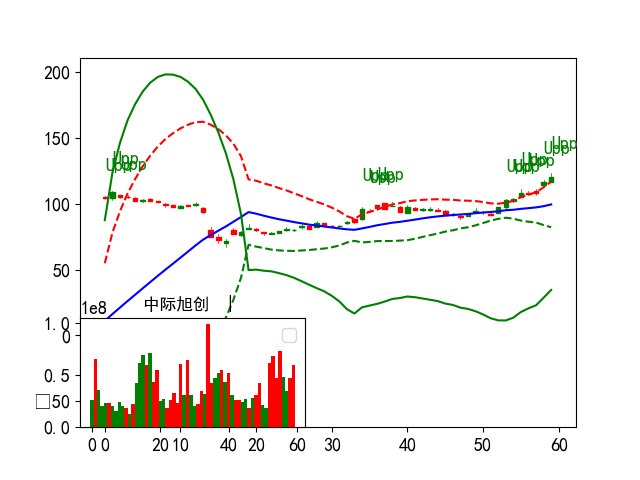

300476 1.84
xratio:0.25 ra_diff:1.84
code: 300476


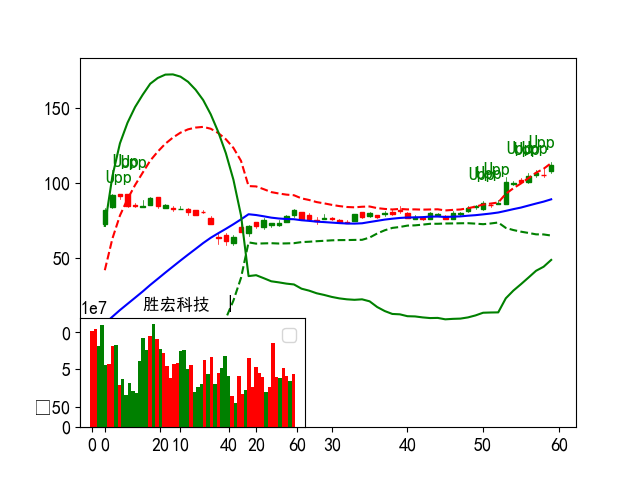

300255 3.12
xratio:0.46 ra_diff:3.12
code: 300255


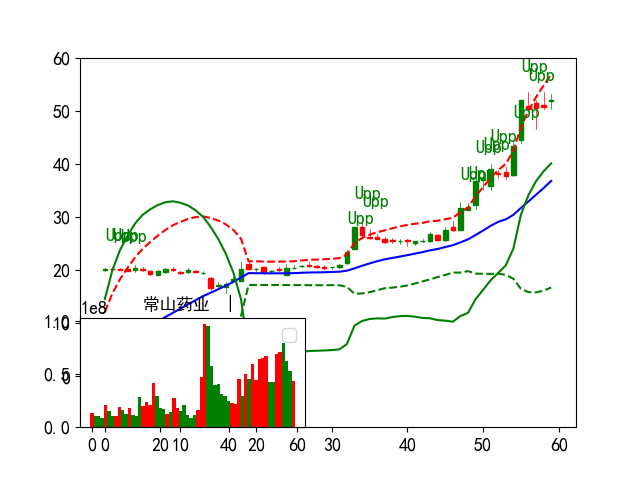

301110 1.69
xratio:0.08 ra_diff:1.69
code: 301110


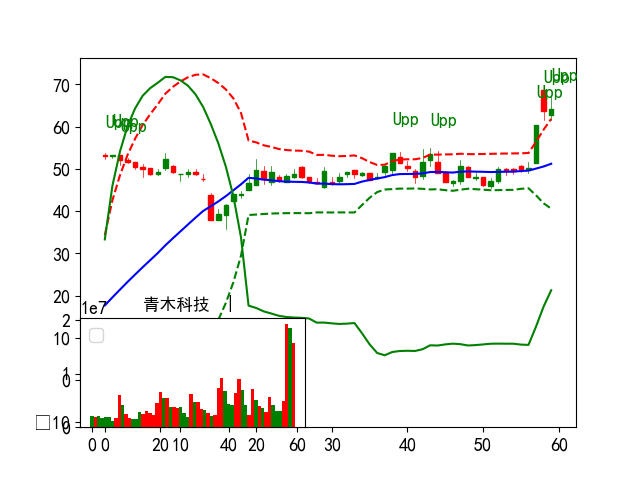

300530 2.23
xratio:0.33 ra_diff:2.23
code: 300530


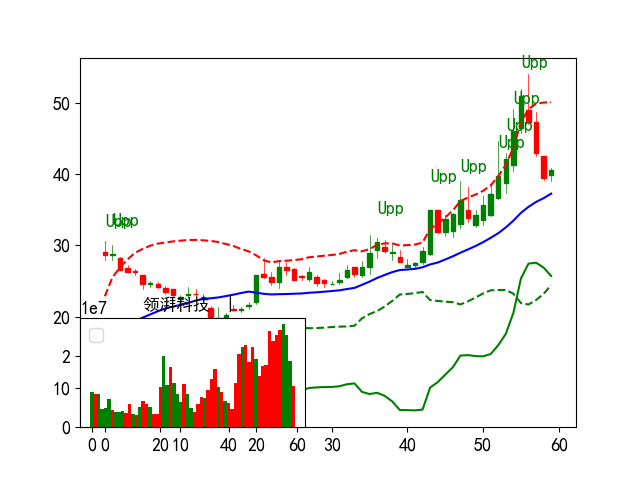

300548 2.09
xratio:0.34 ra_diff:2.09
code: 300548


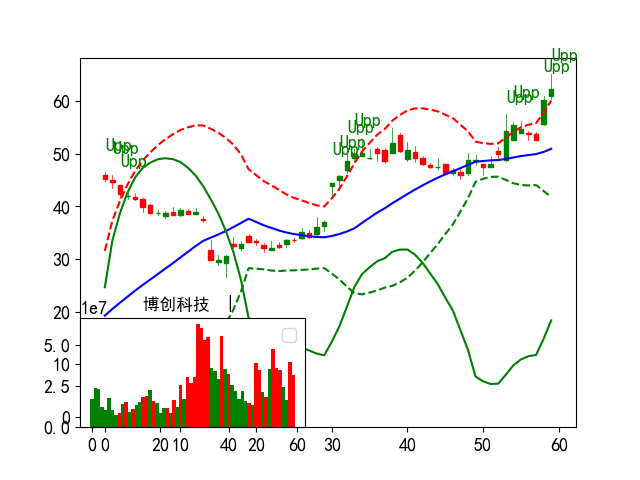

002940 2.34
xratio:0.12 ra_diff:2.34
code: 002940


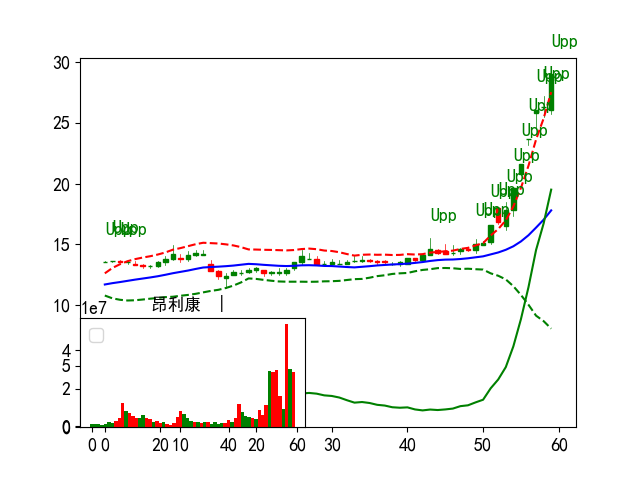

603657 2.36
xratio:0.23 ra_diff:2.36
code: 603657


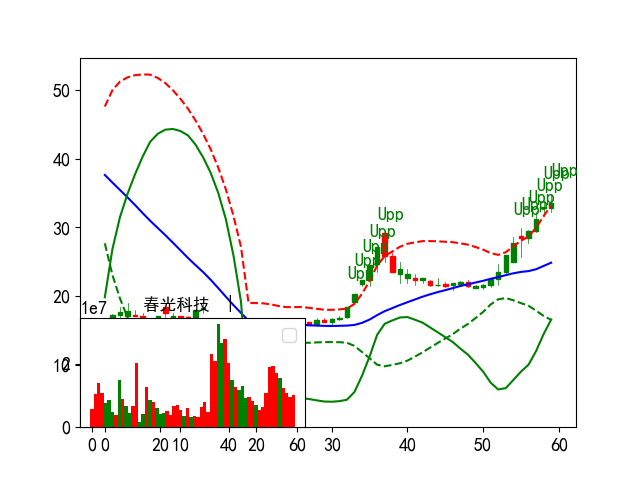

002826 2.6
xratio:0.11 ra_diff:2.6
code: 002826


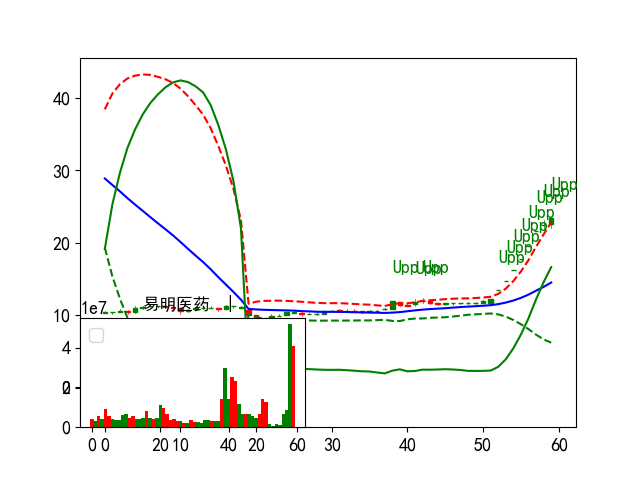

600980 1.88
xratio:0.05 ra_diff:1.88
code: 600980


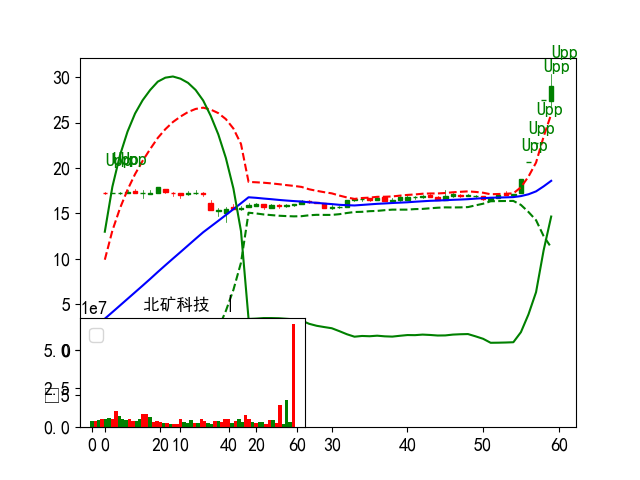

In [105]:
print("df_mask250:%s"%(len(df_mask250.query('couts > 1 and perc > 0'))))
for co in df_mask250.query('couts > 1 and perc > 0').index[:10]:
    print(co,dfs.loc[co].ra_diff[-1])
    show_ohlc_upper(dfsRoot.loc[co][-60:],code=co)

### Tail1 Show Top 主升浪df_masklastd

In [106]:
df_mask250[(df_mask250.date >= lastday_week)][:2]
df_mask250[df_mask250.ra_diff > 1.3].shape

date  lopen  lhigh   llow  close         vol        amount  \
code                                                                      
603129 2025-06-13  212.5  220.5  210.8  211.2   2490991.0  5.405252e+08   
300308 2025-06-16  116.9  123.4  116.9  120.6  59369856.0  7.204022e+09   

        ra_diff    ma10     ma5  ...   idx  couts  nclose  name   open   high  \
code                             ...                                            
603129     1.58  198.10  208.88  ...  34.5      3   212.1  春风动力  218.2  222.0   
300308     1.67  105.06  112.32  ...  27.0      3   121.2  中际旭创  116.9  123.4   

          low  llastp            ticktime  perc  
code                                             
603129  208.4   220.5 2025-06-16 15:00:03 -4.22  
300308  116.9   116.6 2025-06-16 15:00:00  3.43  

[2 rows x 41 columns]

(150, 41)

In [107]:
# df_masklastd = df_mask250[(df_mask250.date >= '2023-02-06') & (df_mask250.perc1d < 21) & (df_mask250.perc2d > 0) &
if resample.upper() =='D':
    df_masklastd = df_mask250[(df_mask250.date >= lastday) & (df_mask250.perc1d < 21) & (df_mask250.perc2d > 0)
                          & ((df_mask250.volsum5d > 10) & (df_mask250.close > df_mask250.ma5) )
                          ]
                          # & ((df_mask250.perc3d > 0) | ((df_mask250.close.shift(2) > df_mask250.ma5.shift(2))) )
else:
    df_masklastd = df_mask250[(df_mask250.date >= lastday_week) & (df_mask250.perc1d < 21) & (df_mask250.perc2d > 0)
                          & ((df_mask250.volsum5d > 20) & (df_mask250.close > df_mask250.ma5) )
                          ]
# (df_mask250.couts == 1) & (df_mask250.perc1d < 21)]

#当下大于上轨
df_masklastd = df_masklastd[df_masklastd.close > df_masklastd.ma5]

print("src:%s  lastd:%s " % (df_mask250.shape, df_masklastd.shape))


if resample.upper() =='M':
    df_masklastd = df_masklastd.sort_values(
        by=['perc1d', 'perc3d'],
        ascending=[0, 0])
else:
    df_masklastd = df_masklastd.sort_values(
        by=['perc3d', 'perc1d'],
        ascending=[0, 0])

# print(
#     (df_masklastd.loc
#      [:, ['name', 'couts', 'date', 'perc1d', 'perc3d', 'perc5d']][:10],
#      df_masklastd.shape,))

# show_tdx_data(df_masklastd)
print(df_masklastd.name.T[:20])
# show_tdx_data(df_masklastd[-10:])


code_t = '300675'
code_t = '605268'
code_t = '002828'
code_t = '300418'
code_t = df_masklastd.index[0]


# df_masklastd.loc[code_t, ['name', 'couts',
#                           'date', 'perc1d', 'perc3d', 'perc5d']]

# df_masklastd.loc[code_t].date


# df_mask250 = groupd250.head(1)

# df_masklastd.loc[code_t].date
# show_tdx_data(df_masklastd.loc[code_t])


# show_tdx_data(df_masklastd.loc[code_t])

src:(228, 41)  lastd:(111, 41) 
code
002878     元隆雅图
600980     北矿科技
300875     捷强装备
002615      哈尔斯
300645     正元智慧
300546     雄帝科技
300333     兆日科技
300157     新锦动力
300468     四方精创
600366     宁波韵升
002558     巨人网络
300689     澄天伟业
301118     恒光股份
301110     青木科技
003029     吉大正元
300886     华业香料
600232    XD金鹰股
301015     百洋医药
002015     协鑫能科
603655     朗博科技
Name: name, dtype: object


### !!! df_mask_hmax 061

df_mask_hmax:412
001203 1.25
xratio:0.01 ra_diff:1.25
code: 001203


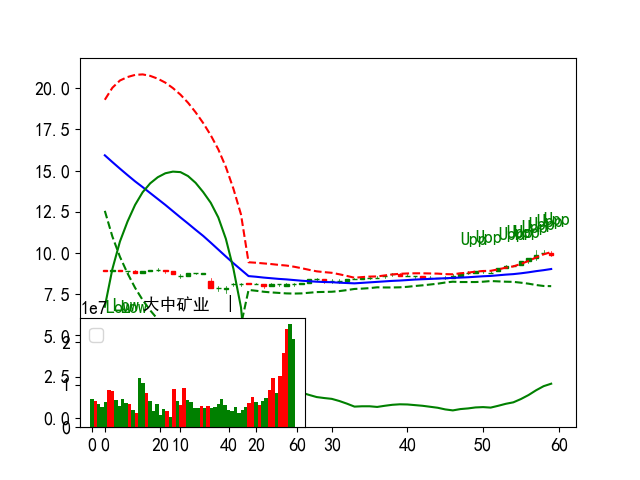

600016 1.26
xratio:0.01 ra_diff:1.26
code: 600016


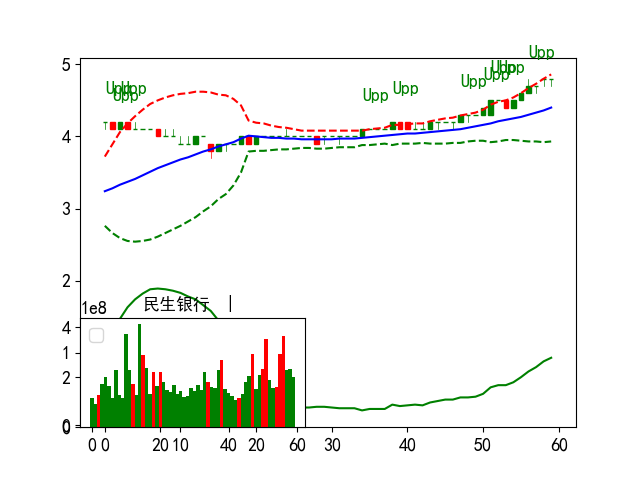

603818 1.84
xratio:0.02 ra_diff:1.84
code: 603818


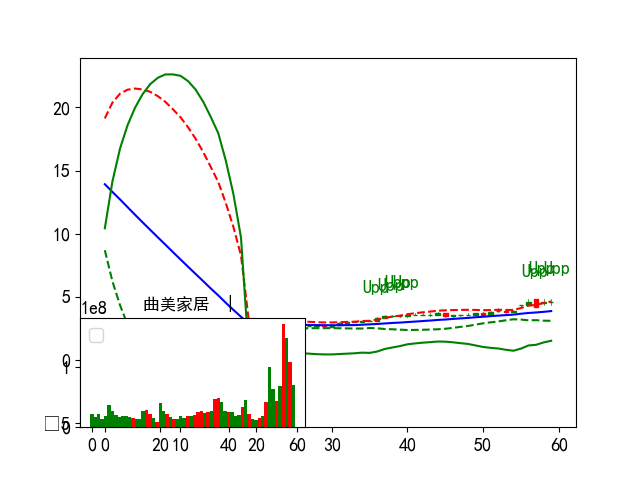

002199 1.79
xratio:0.01 ra_diff:1.79
code: 002199


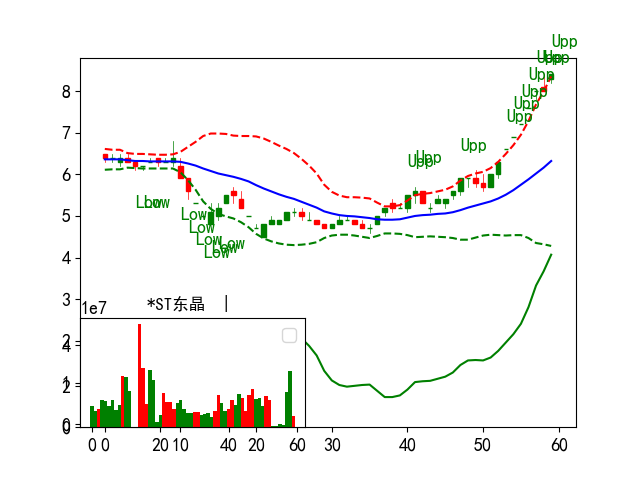

600358 1.97
xratio:0.04 ra_diff:1.97
code: 600358


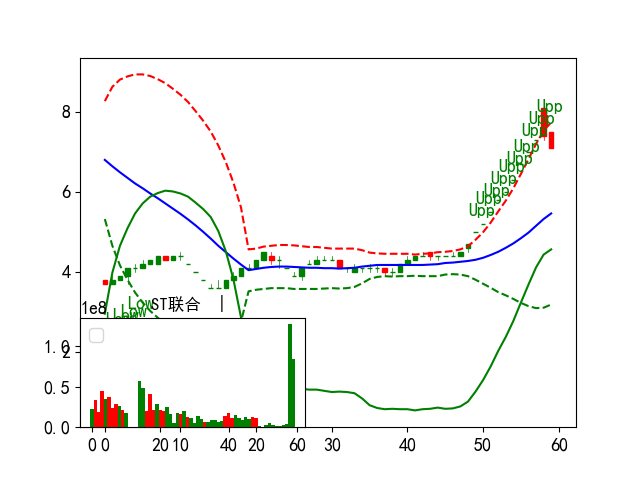

002316 1.53
xratio:0.02 ra_diff:1.53
code: 002316


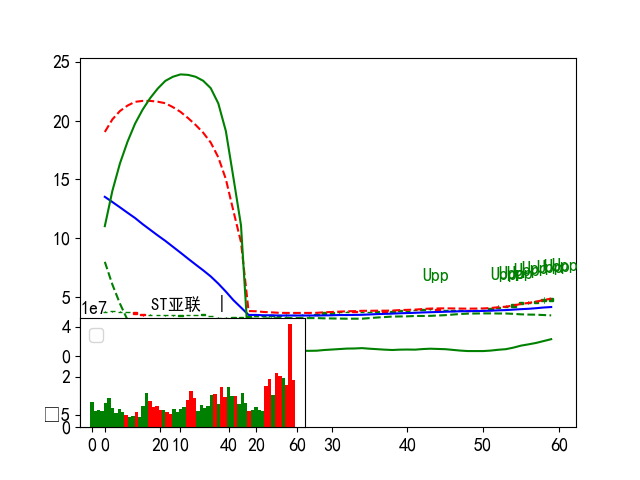

002425 1.75
xratio:0.01 ra_diff:1.75
code: 002425


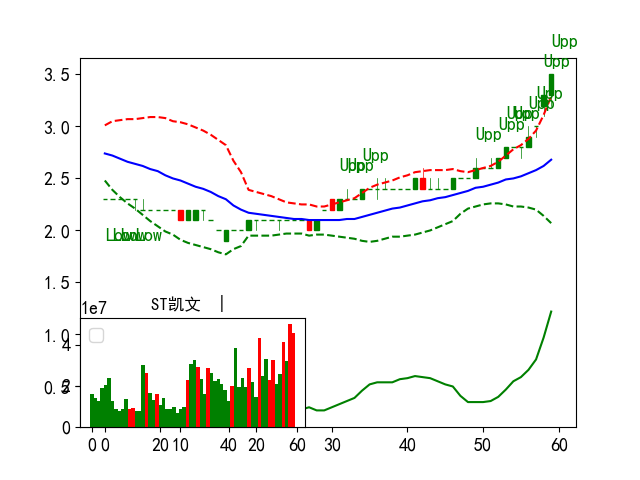

601916 1.21
xratio:0.01 ra_diff:1.21
code: 601916


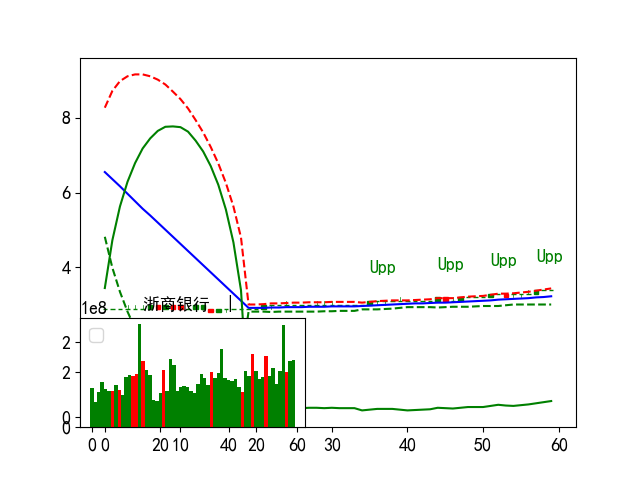

002940 2.34
xratio:0.12 ra_diff:2.34
code: 002940


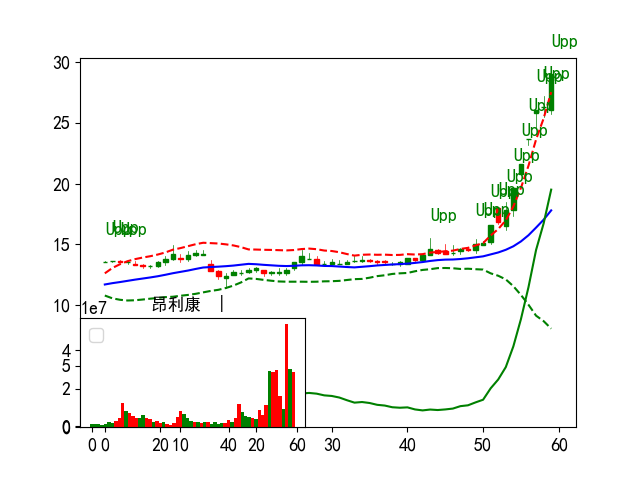

002826 2.6
xratio:0.11 ra_diff:2.6
code: 002826


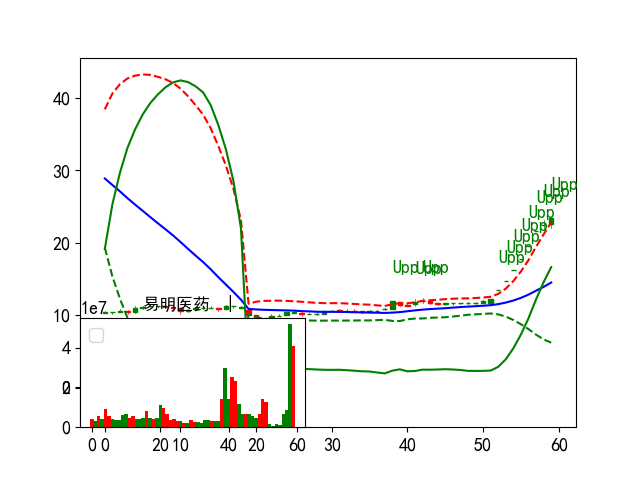

In [108]:
print("df_mask_hmax:%s"%(len(df_mask_hmax)))
for co in df_mask_hmax.index[:10]:
    print(co,dfs.loc[co].ra_diff[-1])
    show_ohlc_upper(dfsRoot.loc[co][-60:],code=co)

###  df_masklastd 068
    show_ohlc_upper(dfs.loc[co][-60:])

df_masklastd:111
002878 2.25
xratio:0.08 ra_diff:2.25
code: 002878


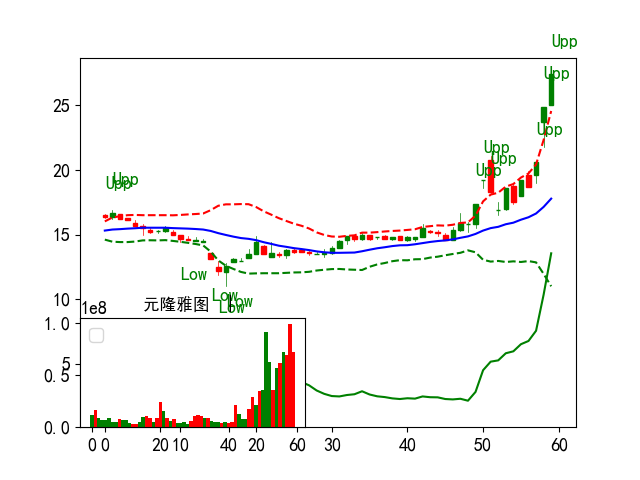

600980 1.88
xratio:0.05 ra_diff:1.88
code: 600980


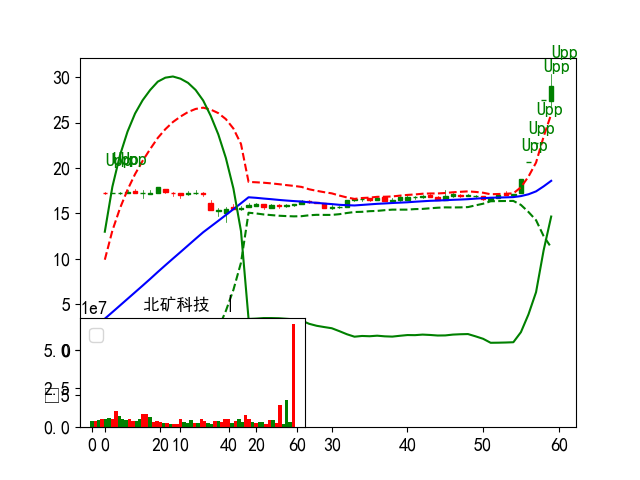

300875 1.74
xratio:0.06 ra_diff:1.74
code: 300875


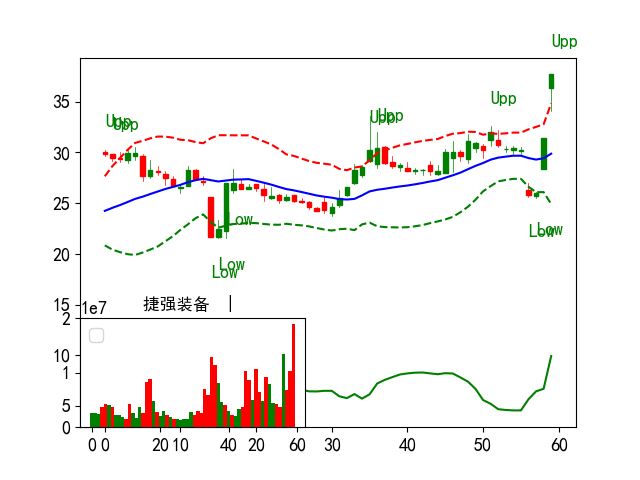

002615 1.67
xratio:0.01 ra_diff:1.67
code: 002615


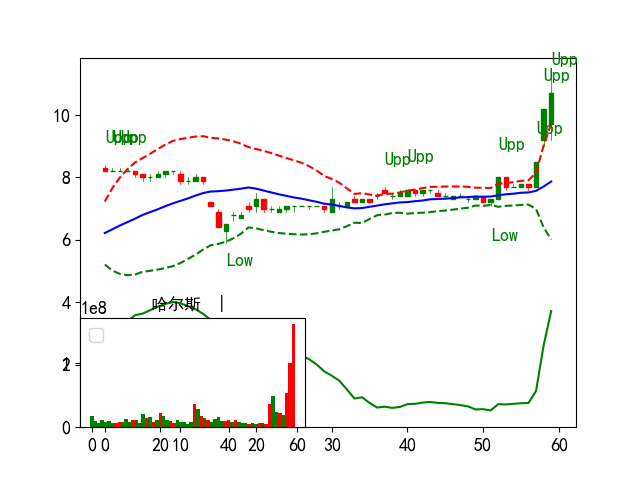

300645 1.73
xratio:0.01 ra_diff:1.73
code: 300645


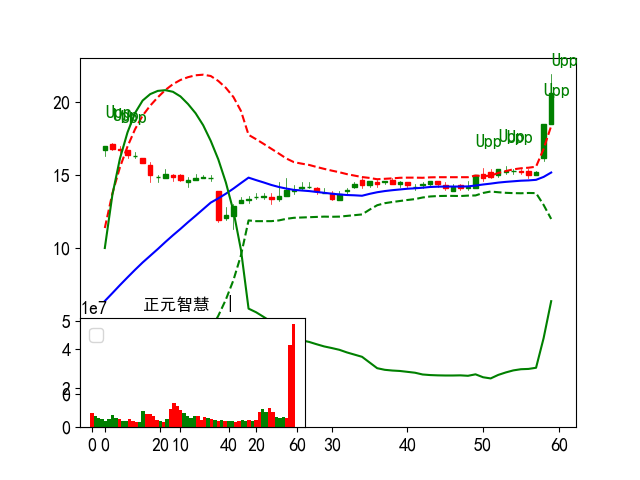

300546 2.6
xratio:0.15 ra_diff:2.6
code: 300546


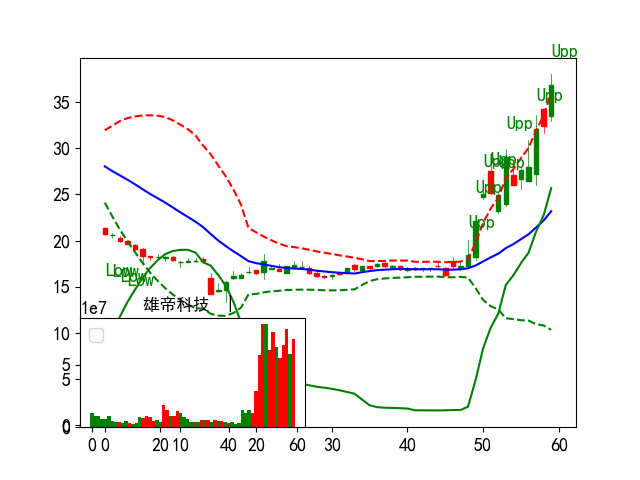

300333 1.7
xratio:0.01 ra_diff:1.7
code: 300333


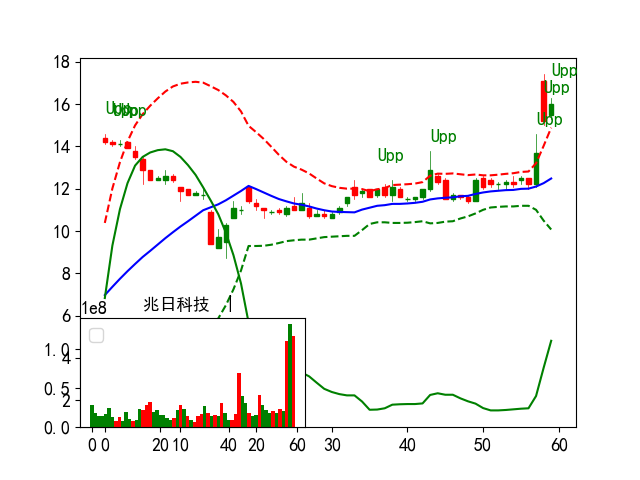

300157 2.12
xratio:0.02 ra_diff:2.12
code: 300157


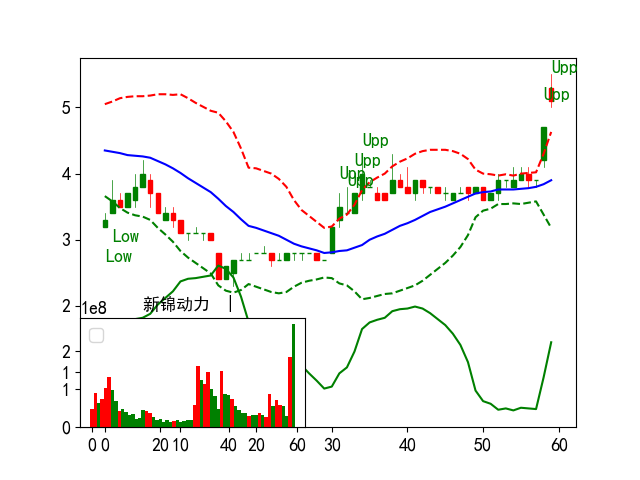

300468 2.4
xratio:0.19 ra_diff:2.4
code: 300468


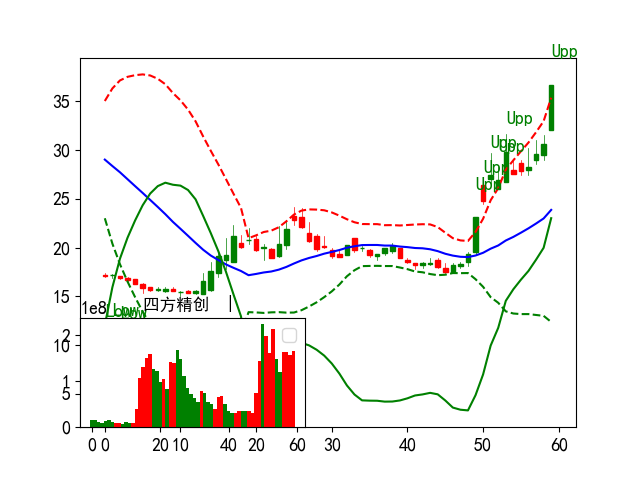

600366 1.63
xratio:0.01 ra_diff:1.63
code: 600366


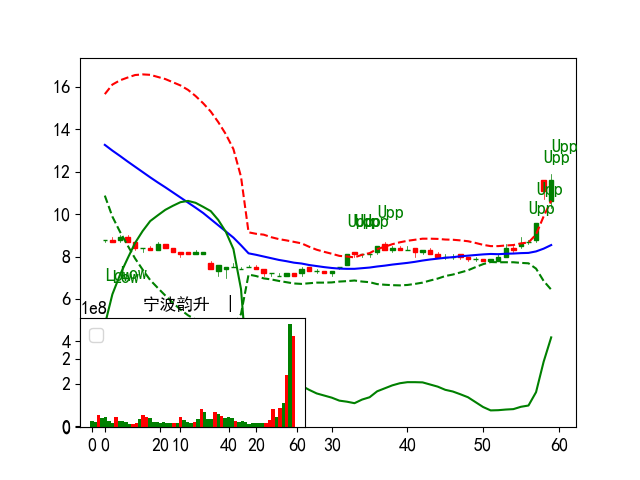

In [109]:
print("df_masklastd:%s"%(len(df_masklastd)))
for co in df_masklastd.index[:10]:
    print(co,dfs.loc[co].ra_diff[-1])
    show_ohlc_upper(dfsRoot.loc[co][-60:],code=co)

### Cross_hmax_250 068

In [110]:
# dfs.loc[code_t].ma5
cross_hmax_250 = [co for co in df_masklastd.index.get_level_values(
    'code') if co in df_mask_hmax.index.get_level_values('code')]
# df_mask250.loc[code_t]
print("cross_hamx:%s" % (len(cross_hmax_250)))
show_tdx_data(df_masklastd.loc[cross_hmax_250][:5])

cross_hamx:97
Count:5 41


name  couts       date   perc  ra_diff  xratio   idx    hat  close  \
code                                                                         
002878  元隆雅图      1 2025-06-16  10.04     2.25    0.39   8.2  13.56   27.4   
600980  北矿科技      3 2025-06-13   5.45     1.79    0.22  10.6  10.94   29.0   
300875  捷强装备      1 2025-06-16  20.06     1.74    0.11   7.5   9.92   37.7   
002615   哈尔斯      1 2025-06-16   4.90     1.67    0.07   3.5   3.72   10.7   
300645  正元智慧      1 2025-06-16  11.35     1.73    0.13   5.8   6.37   20.6   

        volsum5d  ...  ma250  nclose  llow  vol1d   vol2d   vol3d   vol4d  \
code              ...                                                       
002878      37.6  ...  26.42    27.3  25.0 -26.96   43.52   -3.69   16.72   
600980     910.7  ...   8.27    28.8  27.5 -82.22  678.23  -84.81  445.43   
300875     334.3  ...  21.80    37.4  34.1  83.69   52.46  -49.58  261.60   
002615     313.0  ...   6.07    10.6   9.2  60.32   86.93  190.59  -17.50   
300645     782.1  ...  15.28    19.9  18.5  25.45  762.57   -6.54    5.84   

        vol5d  perc3d  perc5d  
code                           
002878   8.01   46.52   56.57  
600980 -45.92   46.28   61.76  
300875 -13.88   46.12   24.01  
002615  -7.35   38.96   38.96  
300645  -5.20   37.33   34.64  

[5 rows x 24 columns]

df_mask250:97
002555 1.14
xratio:-0.01 ra_diff:1.14
code: 002555


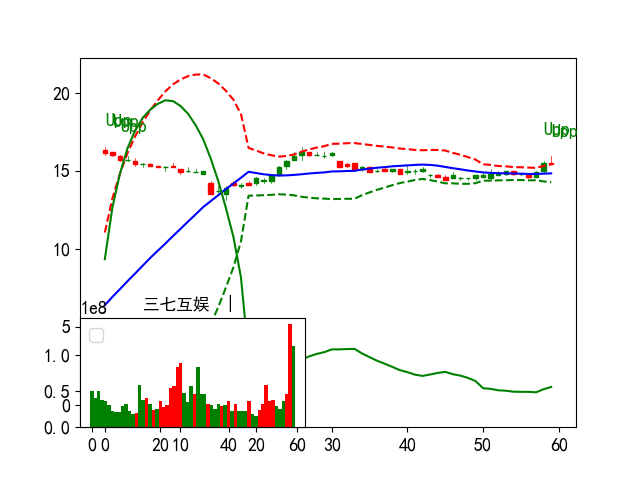

002517 1.2
xratio:0.01 ra_diff:1.2
code: 002517


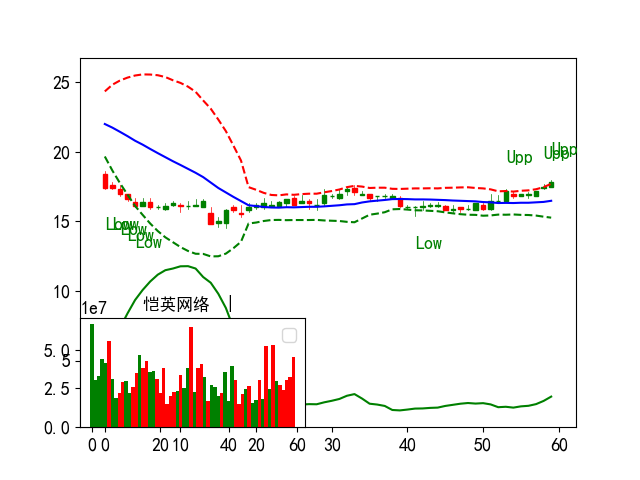

300450 1.3
xratio:-0.01 ra_diff:1.3
code: 300450


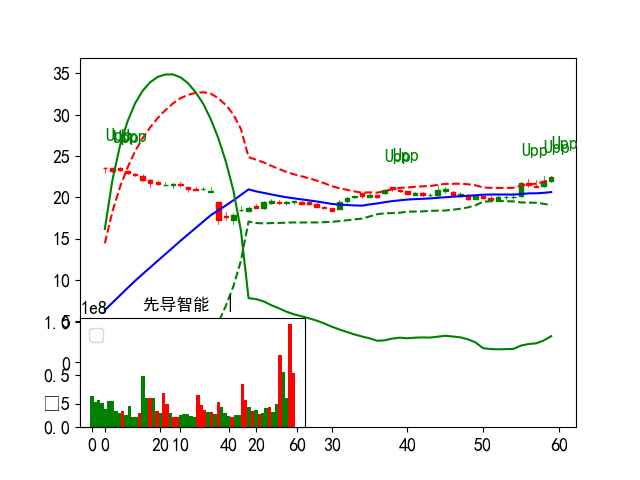

000975 1.16
xratio:0.03 ra_diff:1.16
code: 000975


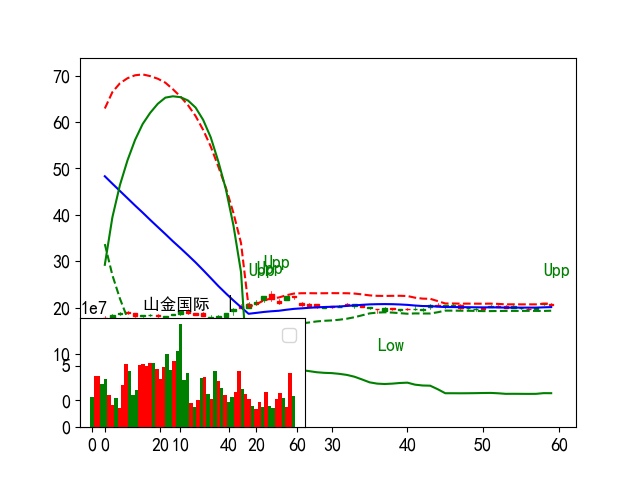

000682 1.13
xratio:-0.01 ra_diff:1.13
code: 000682


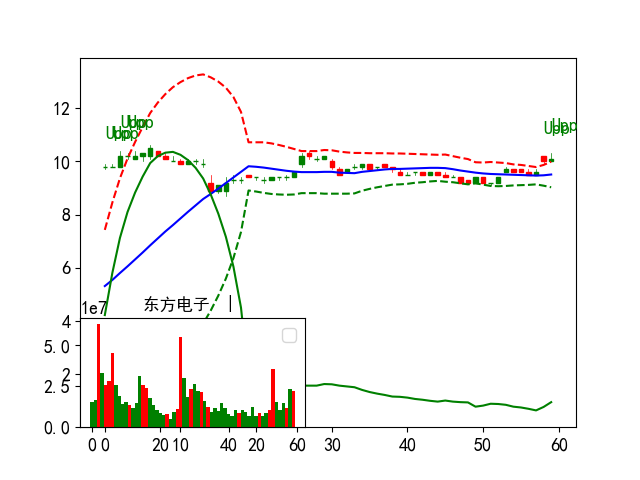

301183 1.24
xratio:-0.09 ra_diff:1.24
code: 301183


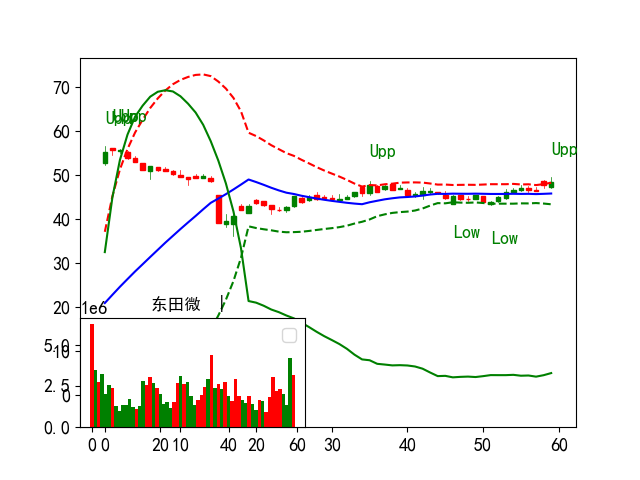

600160 1.26
xratio:0.06 ra_diff:1.26
code: 600160


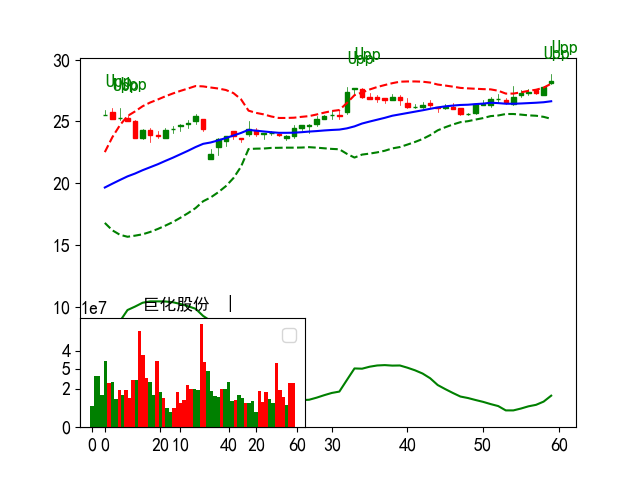

300298 1.13
xratio:-0.04 ra_diff:1.13
code: 300298


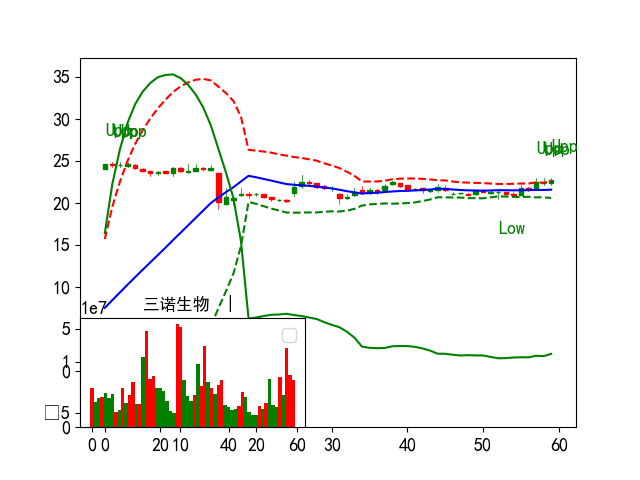

000792 1.1
xratio:-0.01 ra_diff:1.1
code: 000792


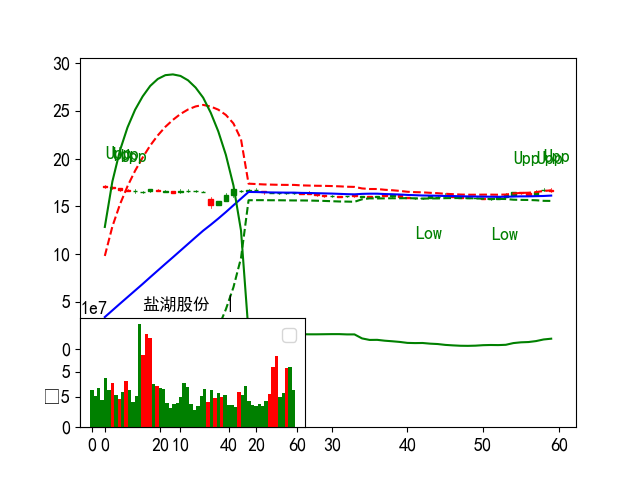

600760 1.32
xratio:0.15 ra_diff:1.32
code: 600760


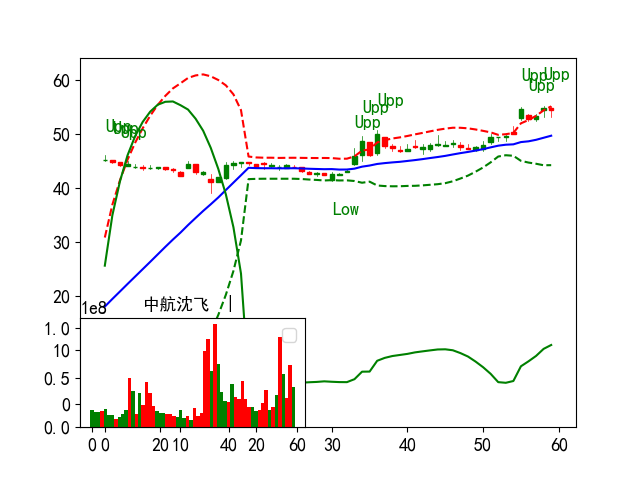

In [111]:
print("df_mask250:%s"%(len(cross_hmax_250)))
# dfs.loc['000002'].shape
for co in cross_hmax_250[-10:]:
    print(co,dfs.loc[co].ra_diff[-1])
    show_ohlc_upper(dfsRoot.loc[co][-60:],code=co)

## 写入061

In [112]:
# write_code_to_blk(df_masklastd.index.tolist(),'061')
# hmax_code = df_mask_hmax[(df_mask_hmax.couts > 1) & (df_mask_hmax.volsum5d > 10) & (df_mask_hmax.volsum5d < 150)].index.tolist()
hmax_code = df_mask_hmax[(df_mask_hmax.couts > 1) ].index.tolist()

# write_code_to_blk(cross_hmax_250,'068')
# write_code_to_blk(hmax_code,'061')

In [113]:
# print(df_masklastd.loc['301255'].date)

# 默认年线筛选

In [114]:
top_temp.shape
top_temp.index

(505, 34)

Index(['603259', '601838', '601717', '600259', '600216', '600039', '300085',
       '002326', '002058', '000001',
       ...
       '603516', '301162', '688332', '300443', '300264', '300149', '002339',
       '000902', '600106', '688676'],
      dtype='object', name='code', length=505)

## plt.close('all')

In [115]:
# plt.close('all')

# 写入060